In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import KaplanMeierFitter, CoxPHFitter, WeibullFitter, LogNormalFitter, LogLogisticFitter
from lifelines.plotting import qq_plot
import featuretools as ft
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from featuretools.primitives import make_agg_primitive
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression, Lasso, BayesianRidge, Ridge
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers.core import Dense, Activation
%matplotlib inline

Using TensorFlow backend.


### Importing data

In [2]:
# naming the columns
names = ['asset_id', 'runtime', 'setting_1', 'setting_2', 'setting_3']
names.extend([f'tag_{i + 1}' for i in range(23)])

In [3]:
df_train = pd.read_csv('PM_train.txt', sep=' ', header=None, names=names)
df_test = pd.read_csv('PM_test.txt', sep=' ', header=None, names=names)

### Analyzing data

In [4]:
df_train.shape, df_test.shape

((20631, 28), (13096, 28))

First, let's see if there are any null values in the dataset

In [5]:
# looking for missing data
df_missing = pd.concat([df_train.isnull().sum(), df_test.isnull().sum()], axis=1)
df_missing.columns = ['train', 'test']
df_missing

,train,test
asset_id,0,0
runtime,0,0
setting_1,0,0
setting_2,0,0
setting_3,0,0
tag_1,0,0
tag_2,0,0
tag_3,0,0
tag_4,0,0
tag_5,0,0


The last two columns presented a great amount of null values, so I dropped them from the dataset.

In [8]:
# dropping columns with missing values
drop_col = ['tag_22', 'tag_23']
df_train.drop(drop_col, axis=1, inplace=True)
df_test.drop(drop_col, axis=1, inplace=True)

Now let's plot the values of each column for the first asset_id to have an idea of how they behave along the time.

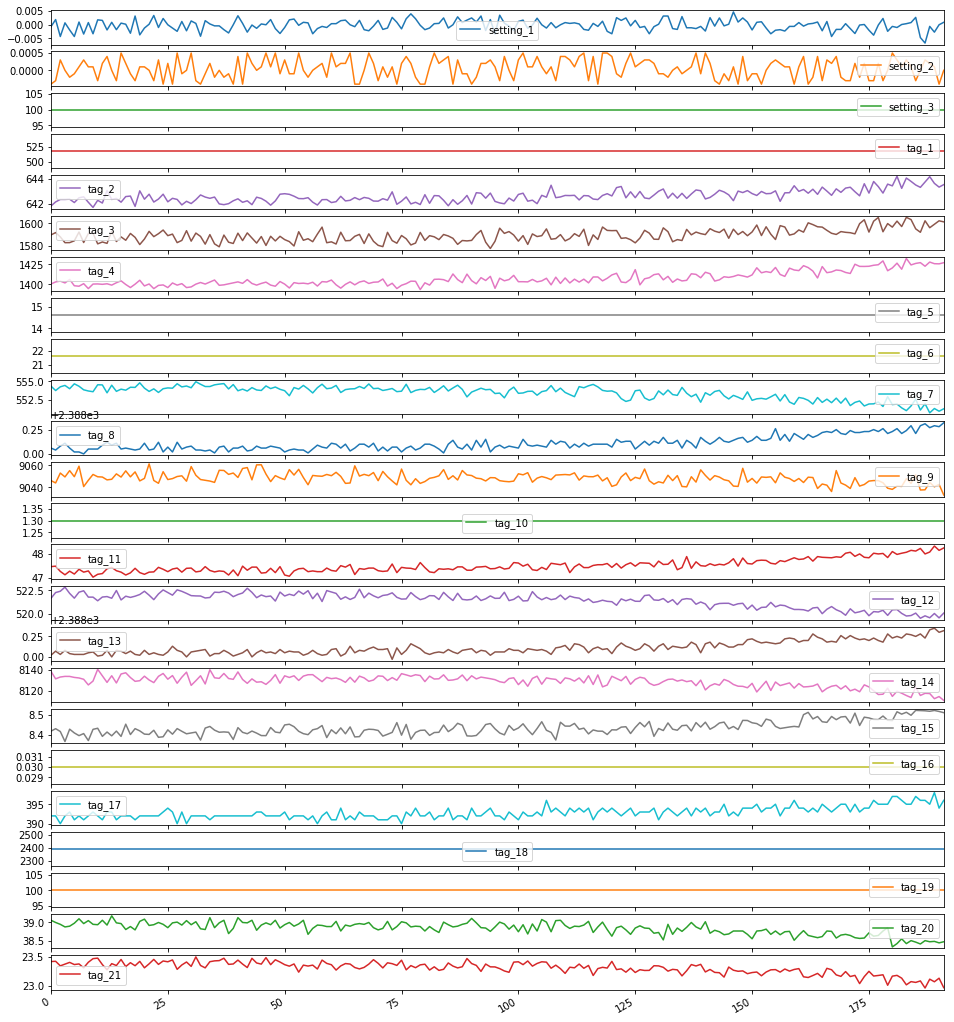

In [9]:
# plotting sensor data for a asset_id
df_train_1 = df_train[df_train['asset_id'] == 1]
df_train_1[df_train.columns[2:]].plot(subplots=True, sharex=True, figsize=(16,20))
plt.show()

It seems that some columns do not change along the time.

Let's plot the boxplot of each column for each asset_id to confirm if they remain constant for other assets

<-----Column: setting_1---->


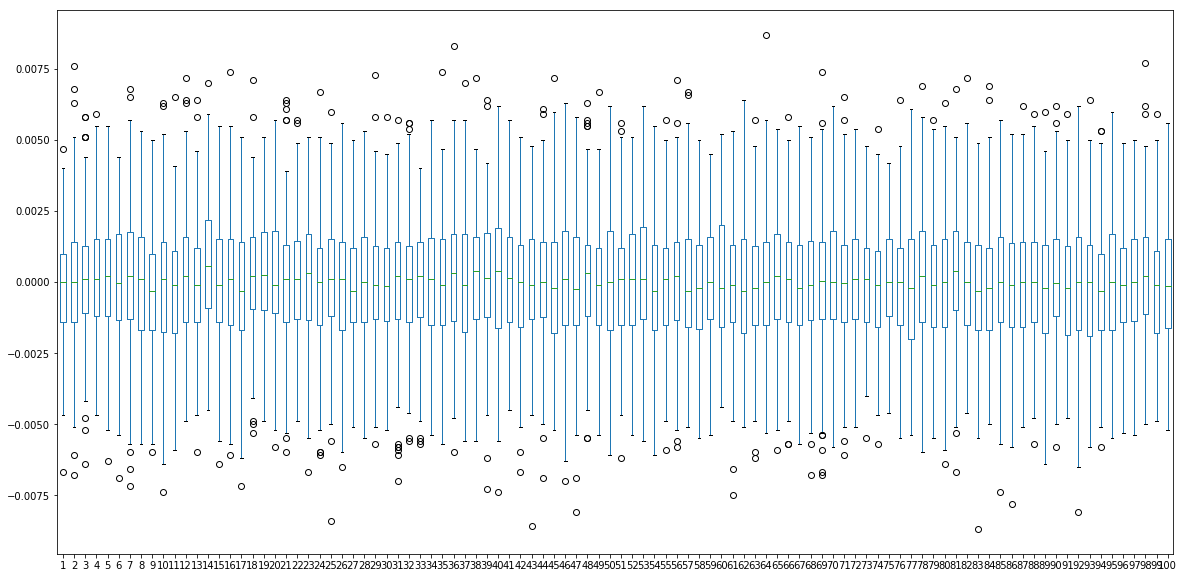

<-----Column: setting_2---->


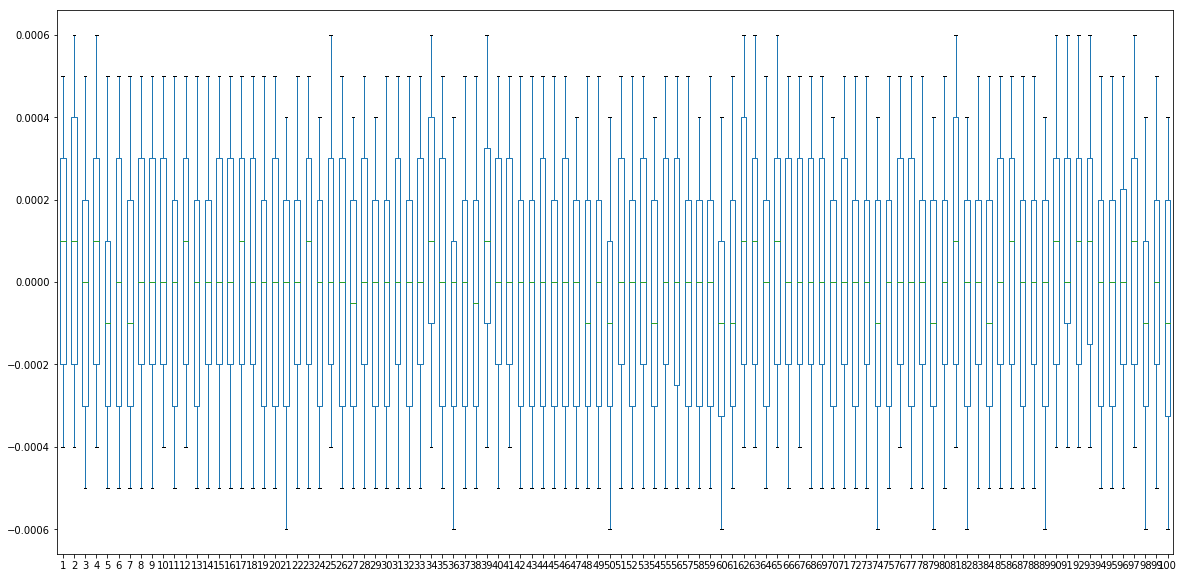

<-----Column: setting_3---->


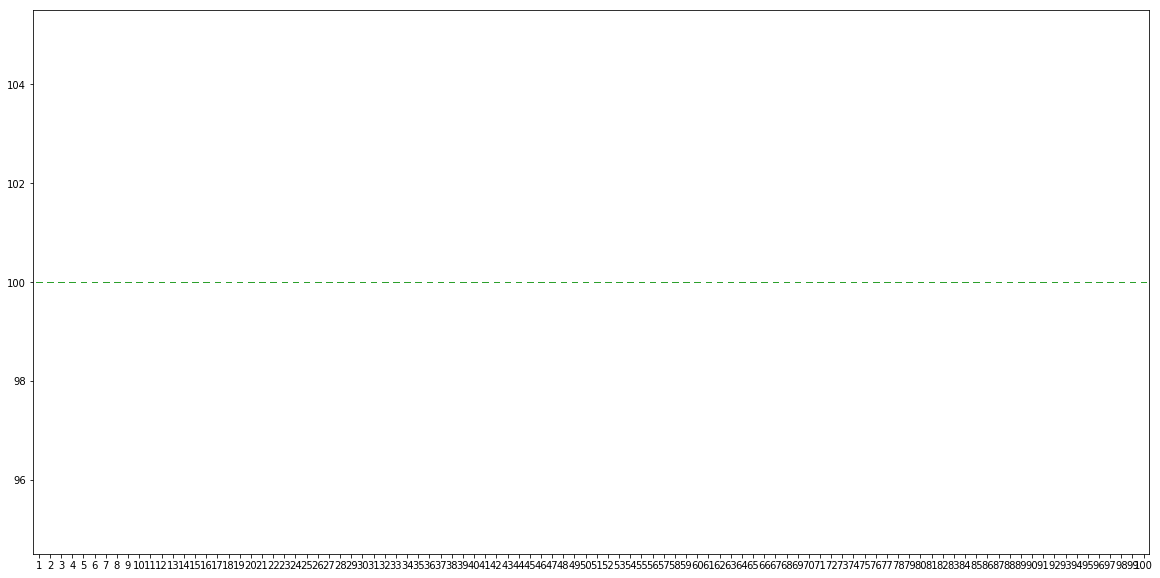

<-----Column: tag_1---->


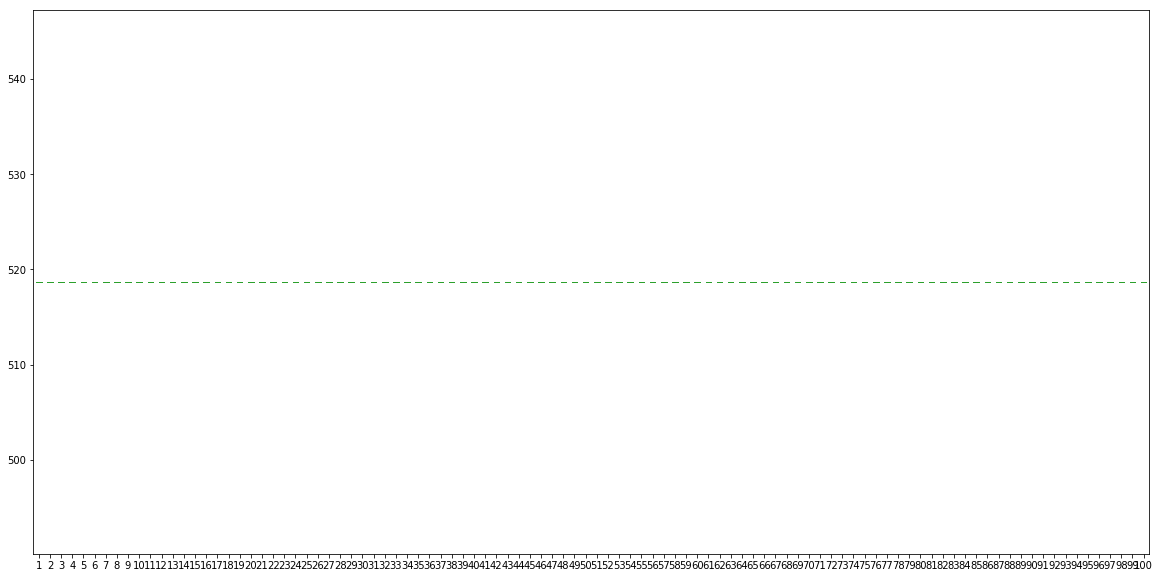

<-----Column: tag_2---->


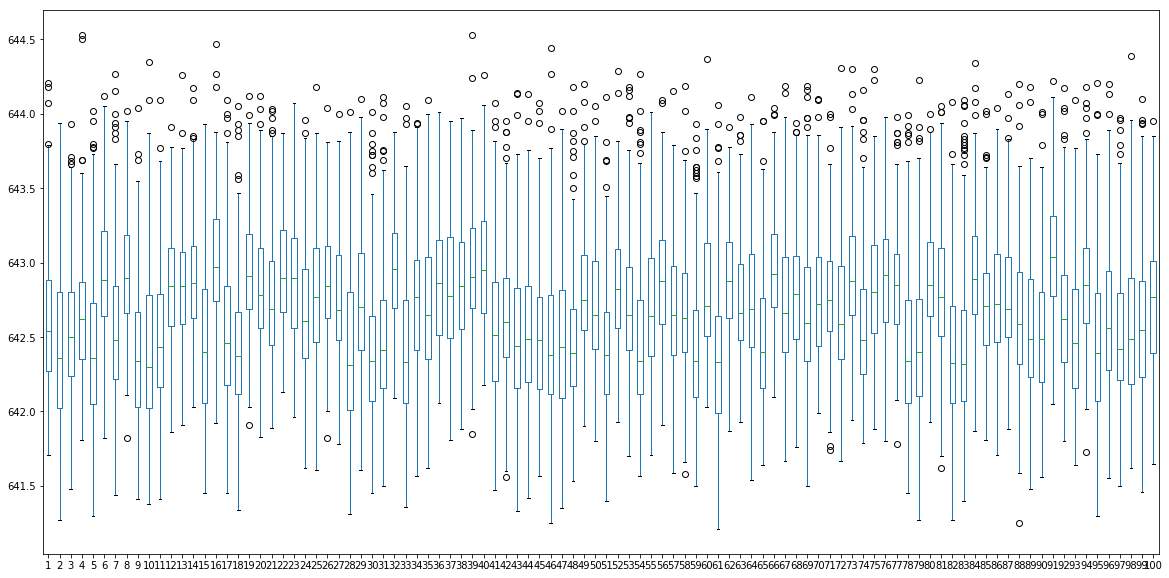

<-----Column: tag_3---->


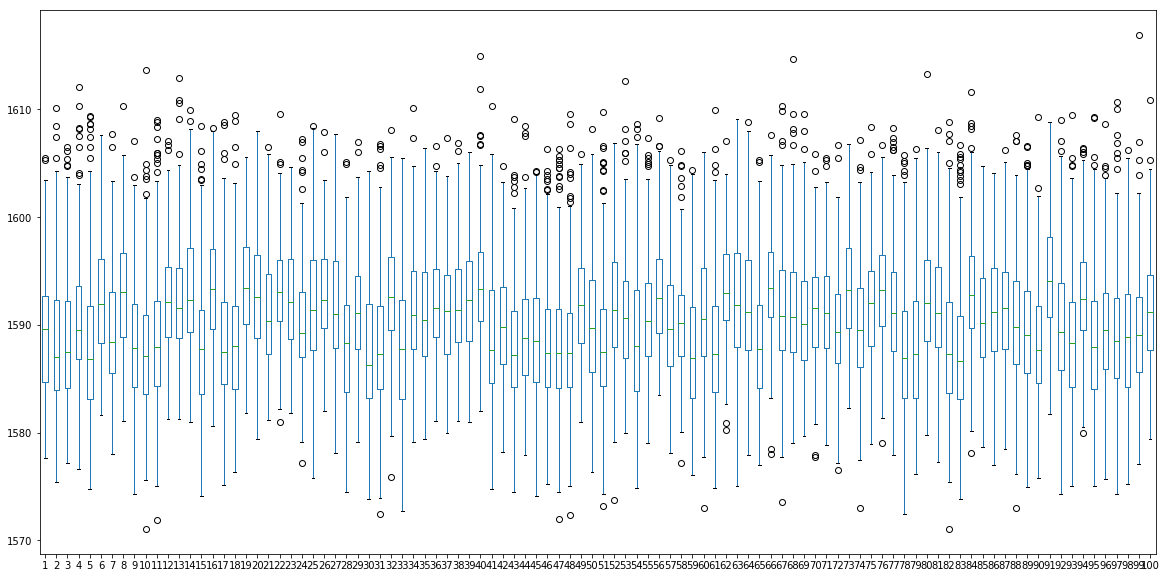

<-----Column: tag_4---->


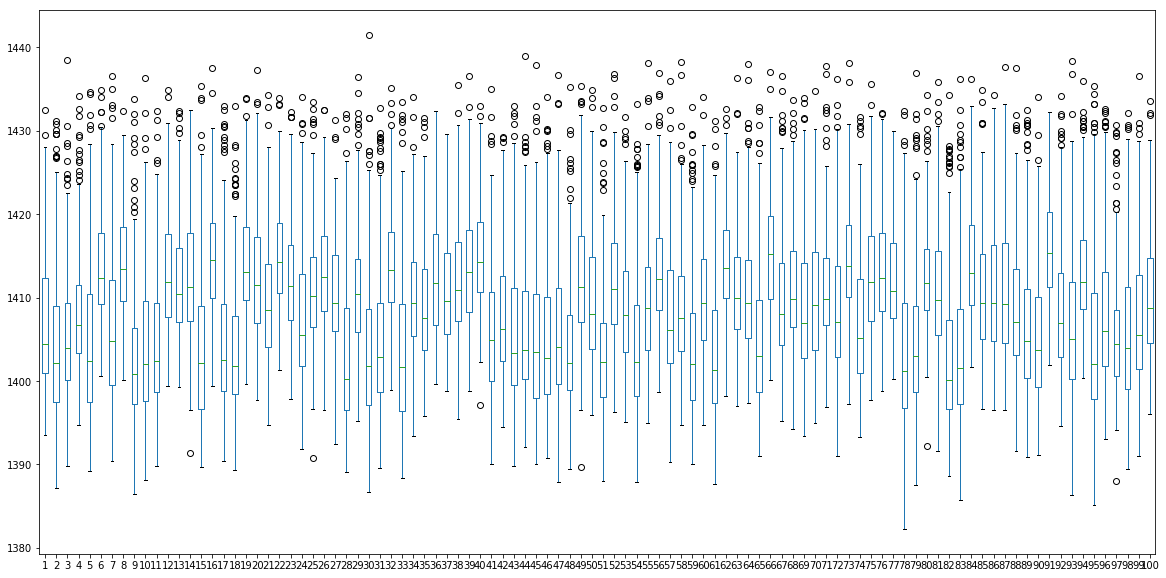

<-----Column: tag_5---->


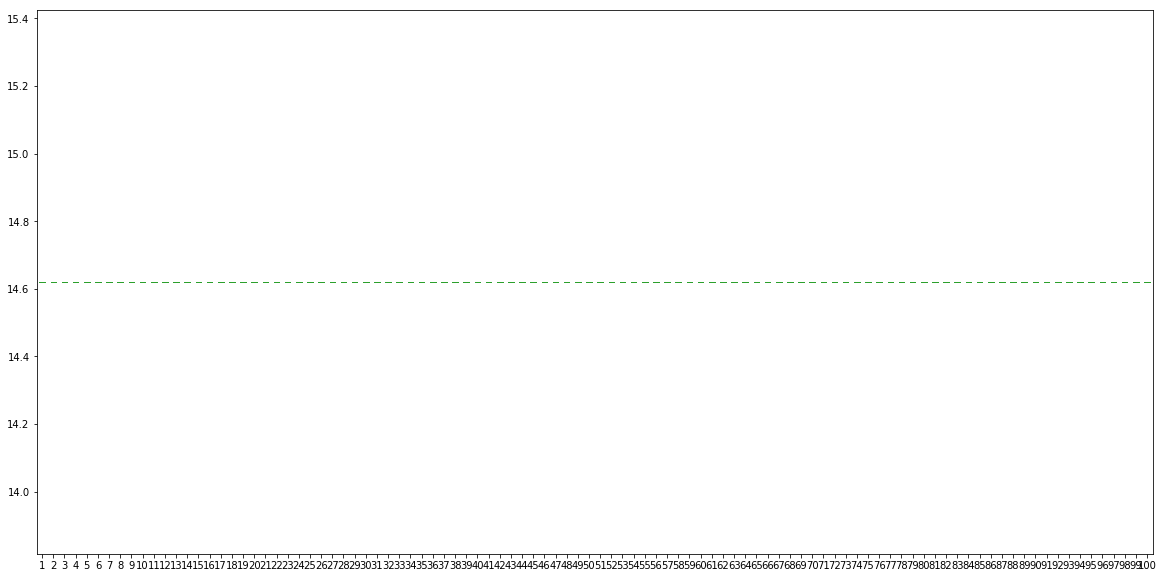

<-----Column: tag_6---->


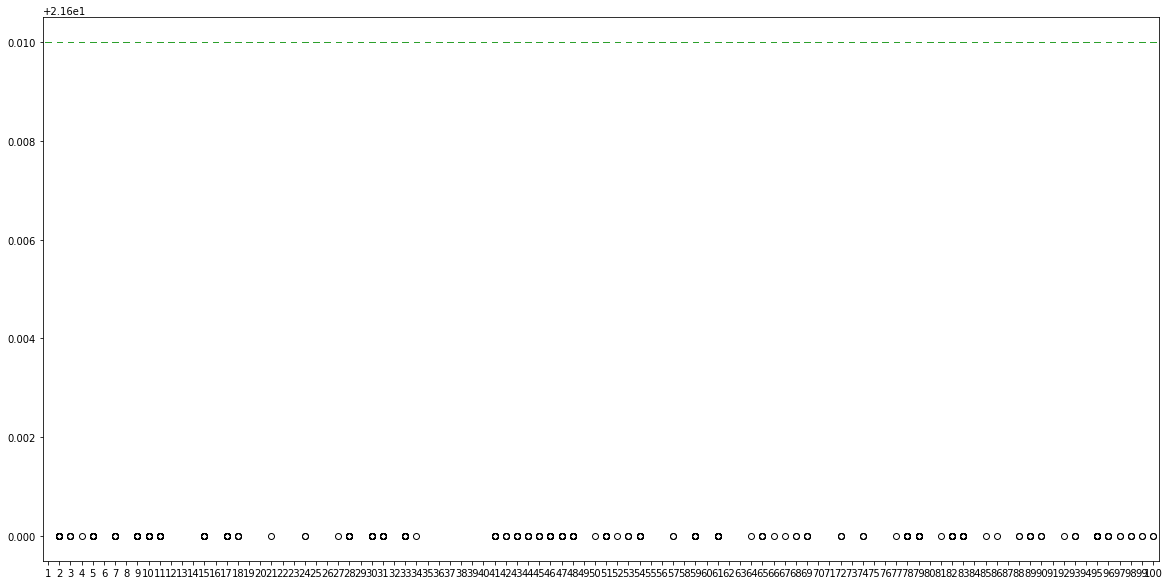

<-----Column: tag_7---->


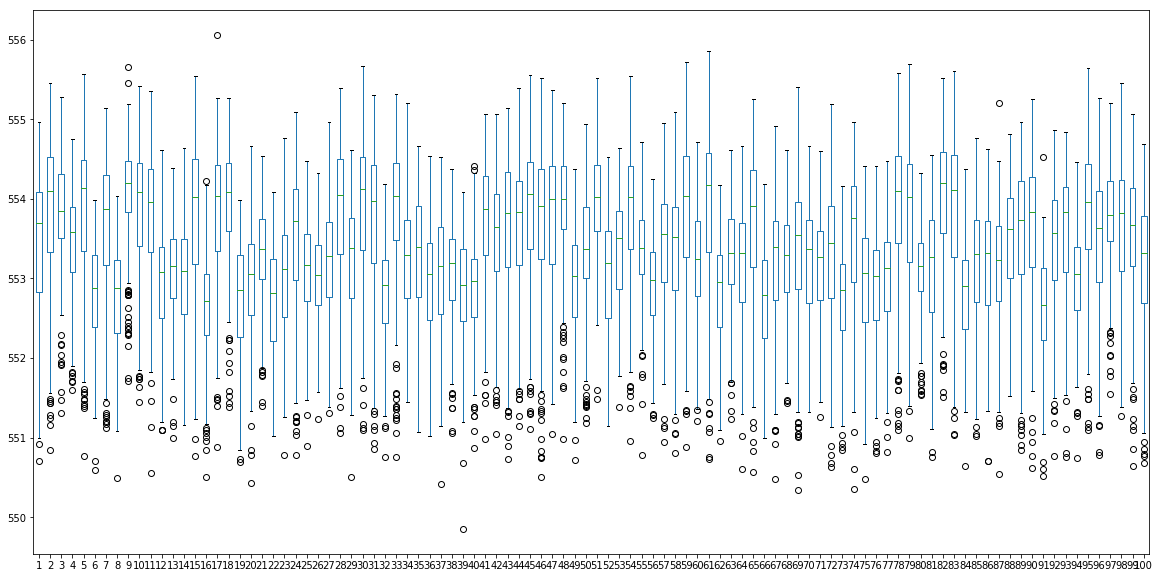

<-----Column: tag_8---->


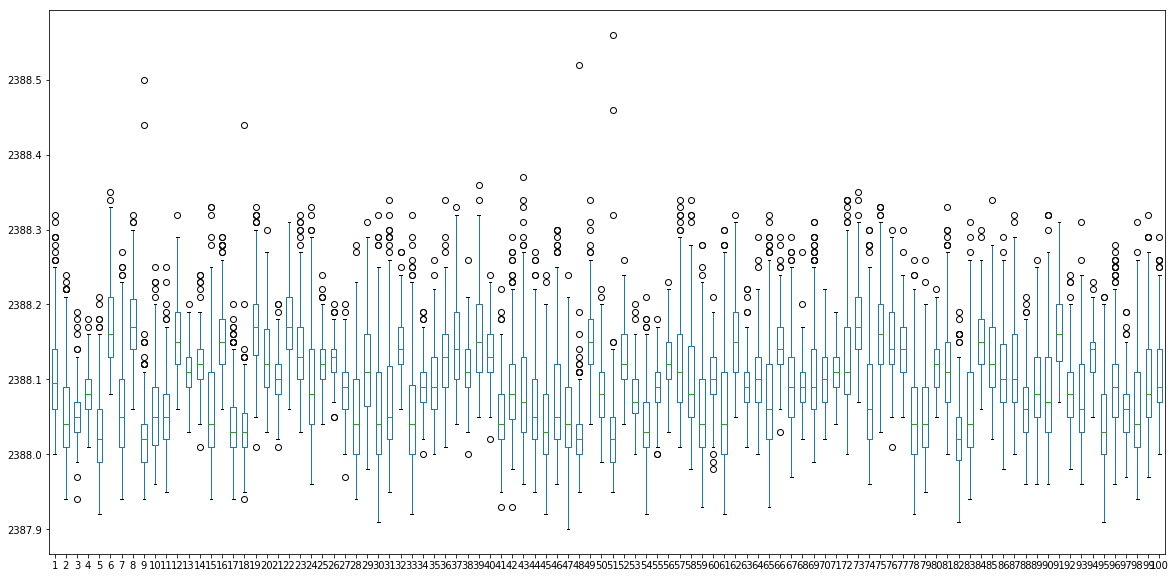

<-----Column: tag_9---->


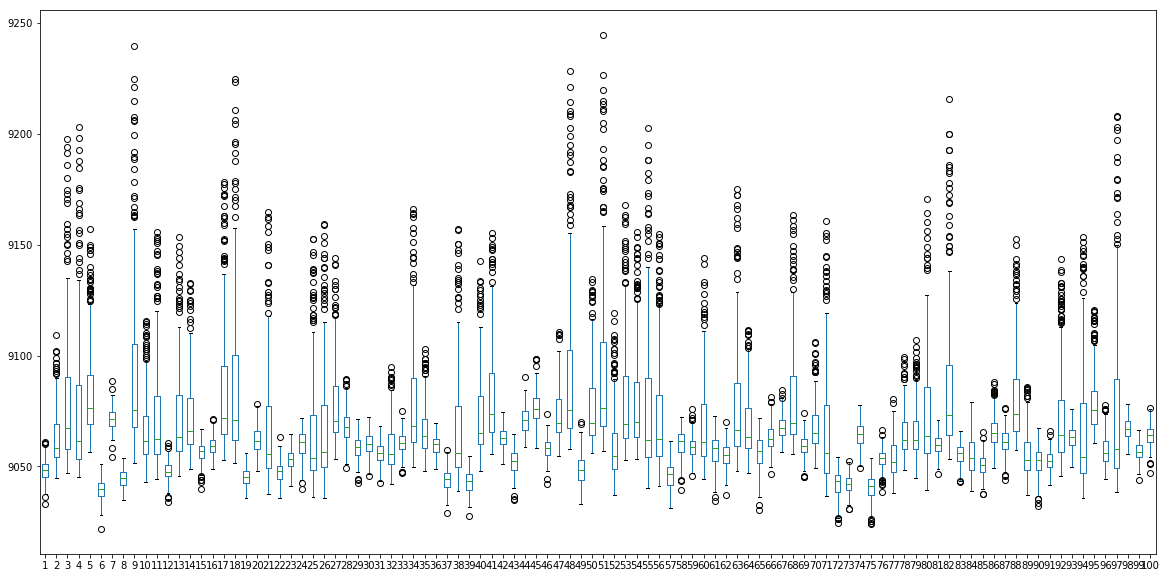

<-----Column: tag_10---->


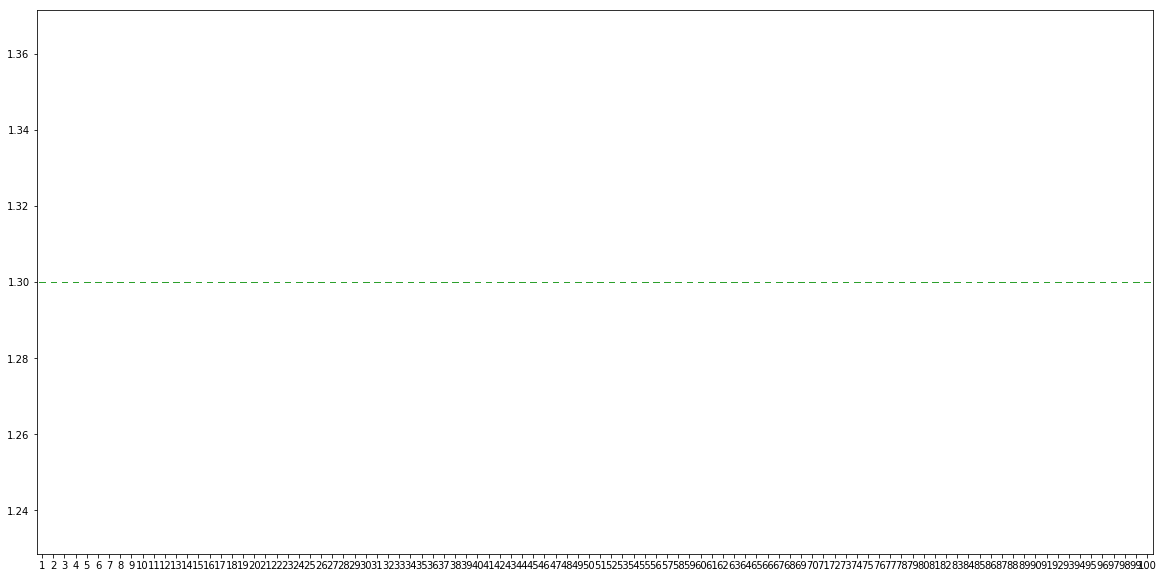

<-----Column: tag_11---->


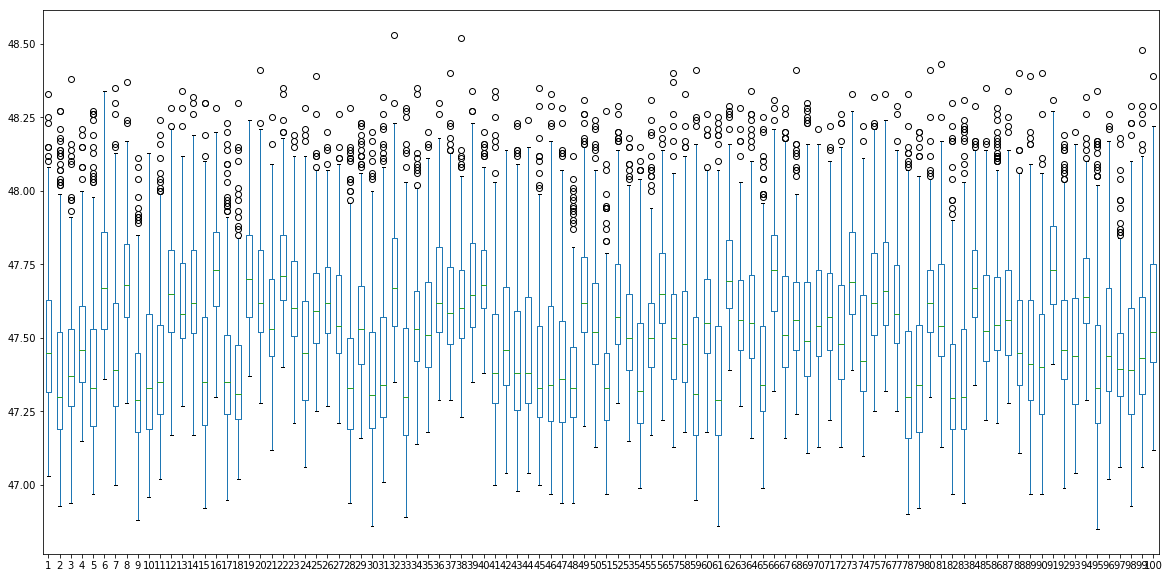

<-----Column: tag_12---->


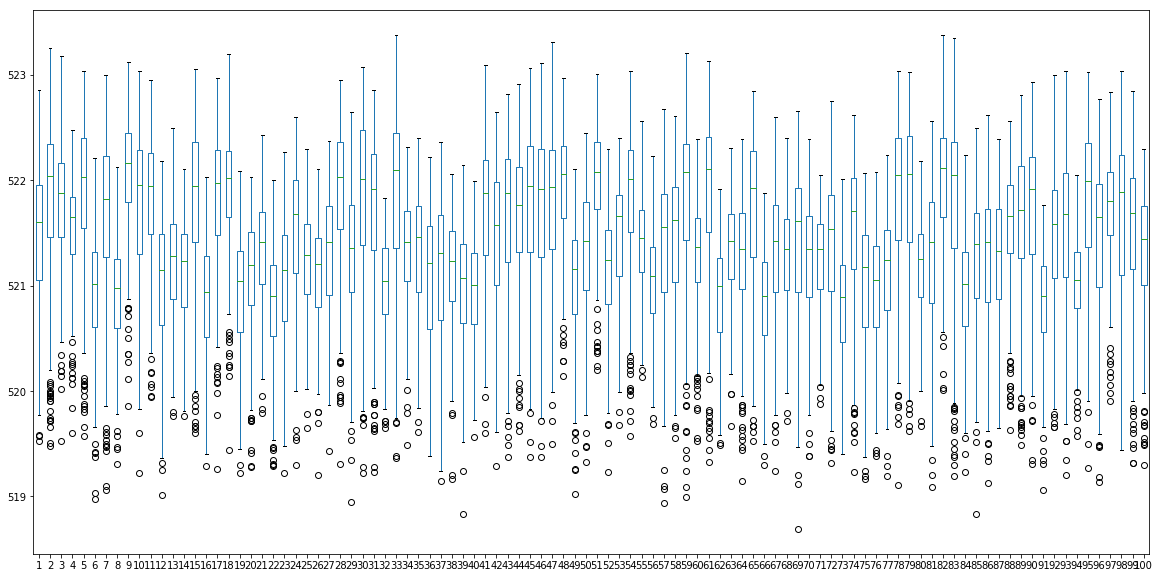

<-----Column: tag_13---->


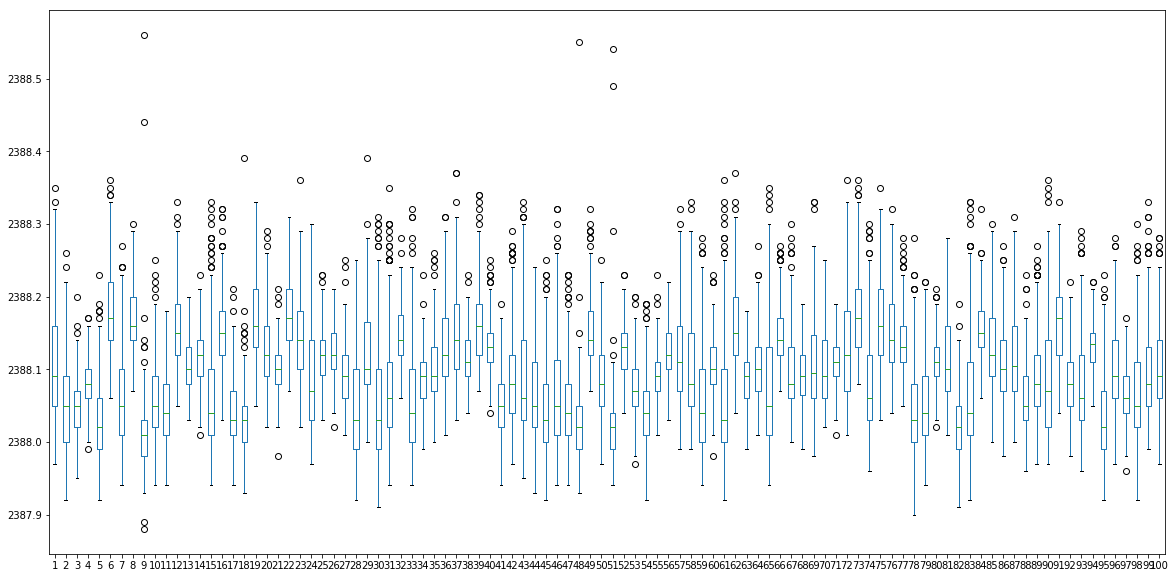

<-----Column: tag_14---->


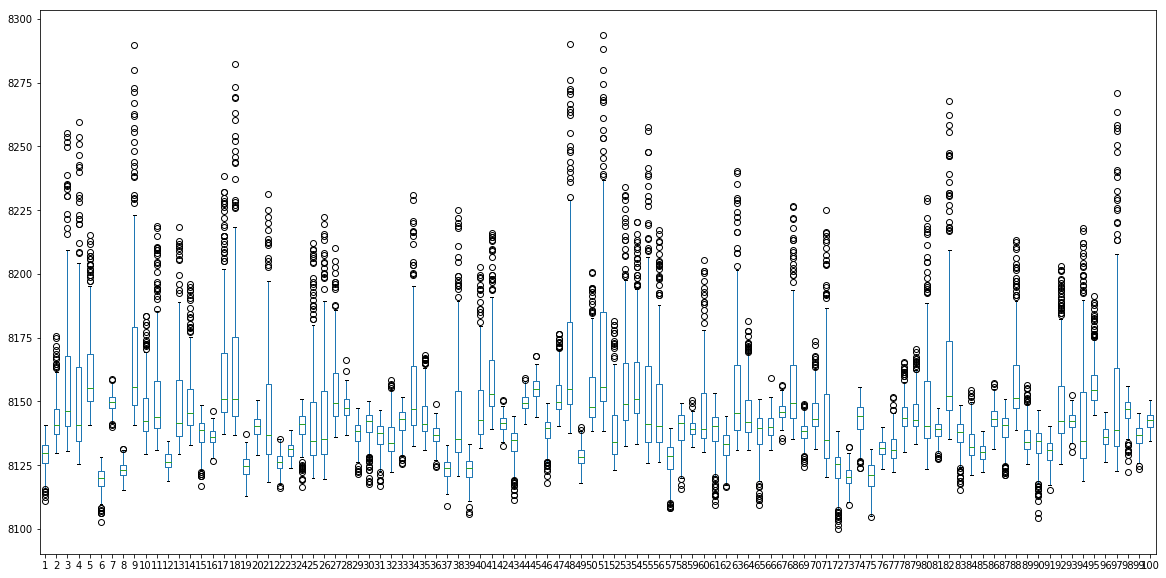

<-----Column: tag_15---->


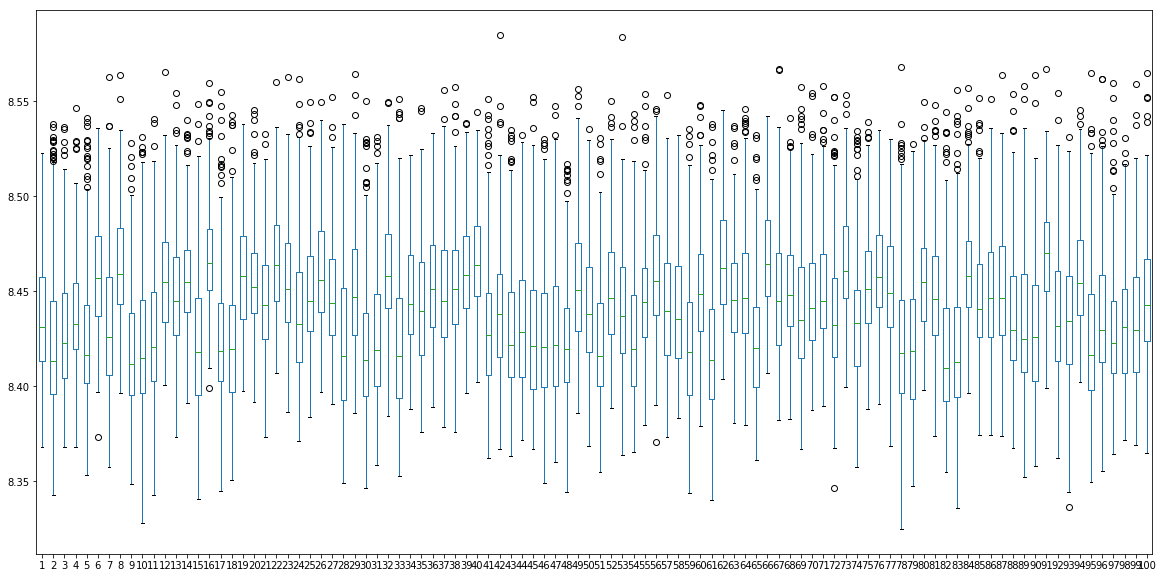

<-----Column: tag_16---->


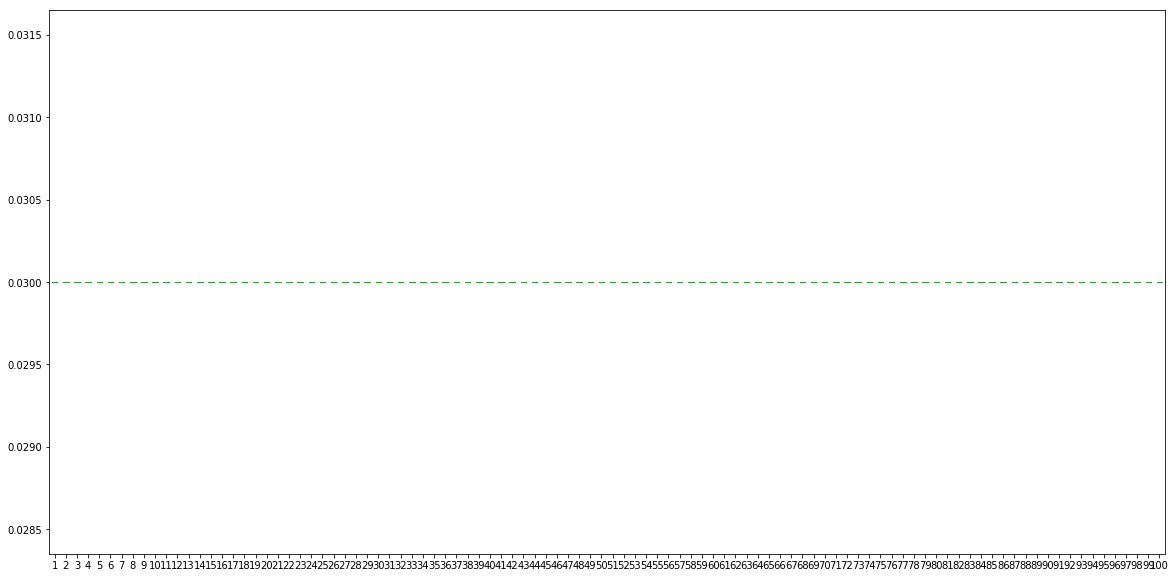

<-----Column: tag_17---->


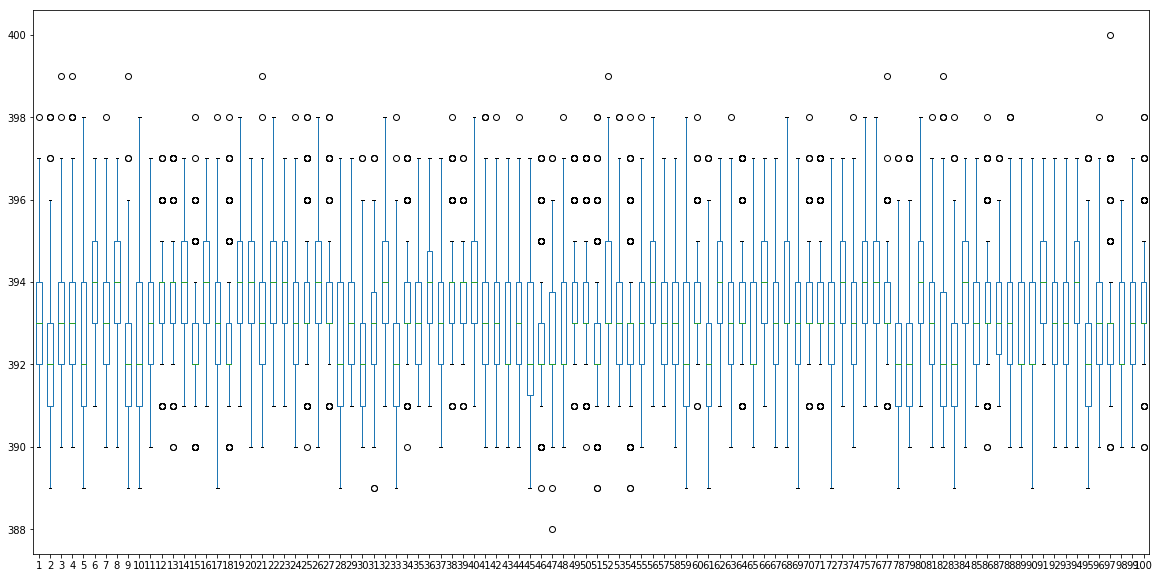

<-----Column: tag_18---->


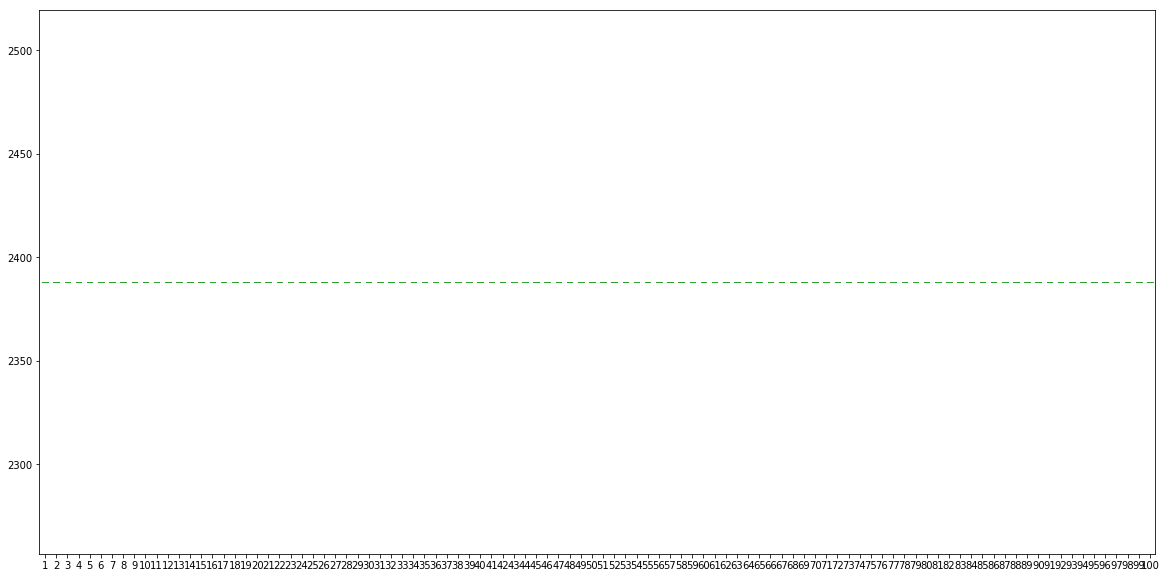

<-----Column: tag_19---->


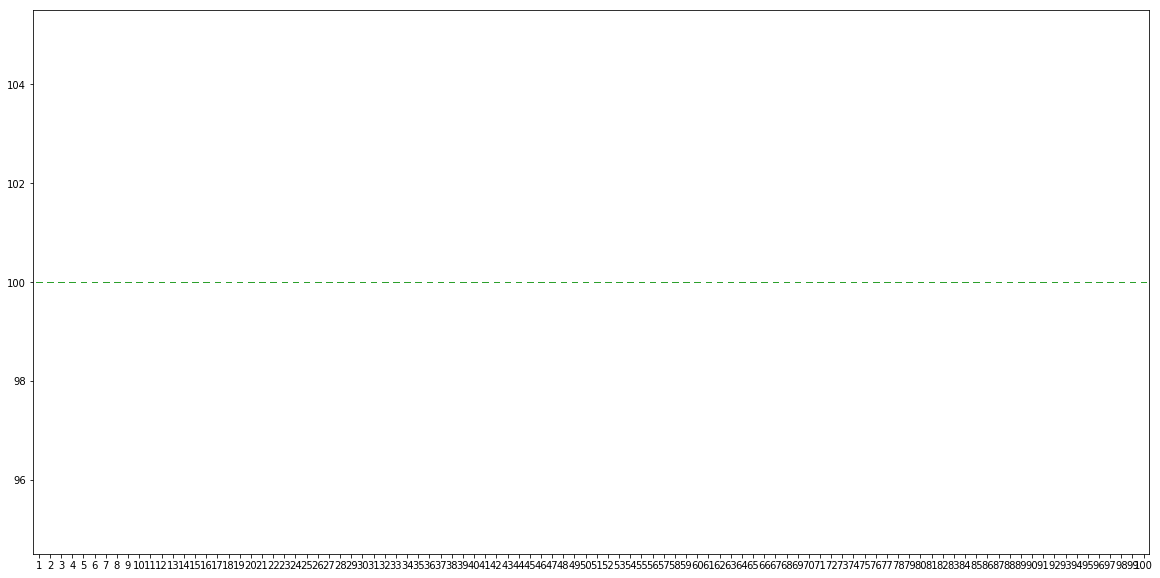

<-----Column: tag_20---->


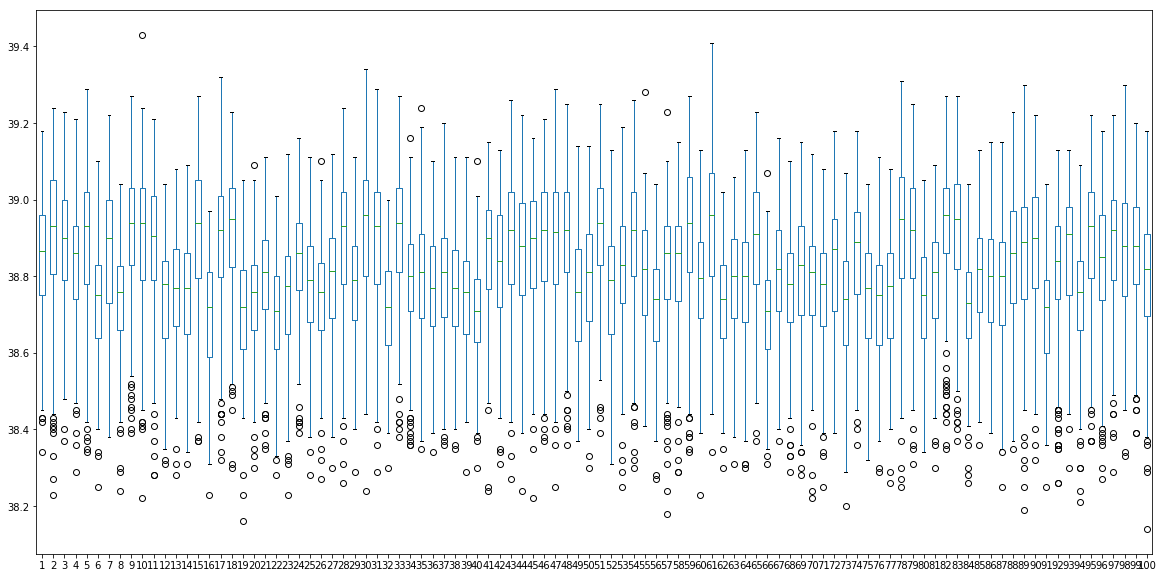

<-----Column: tag_21---->


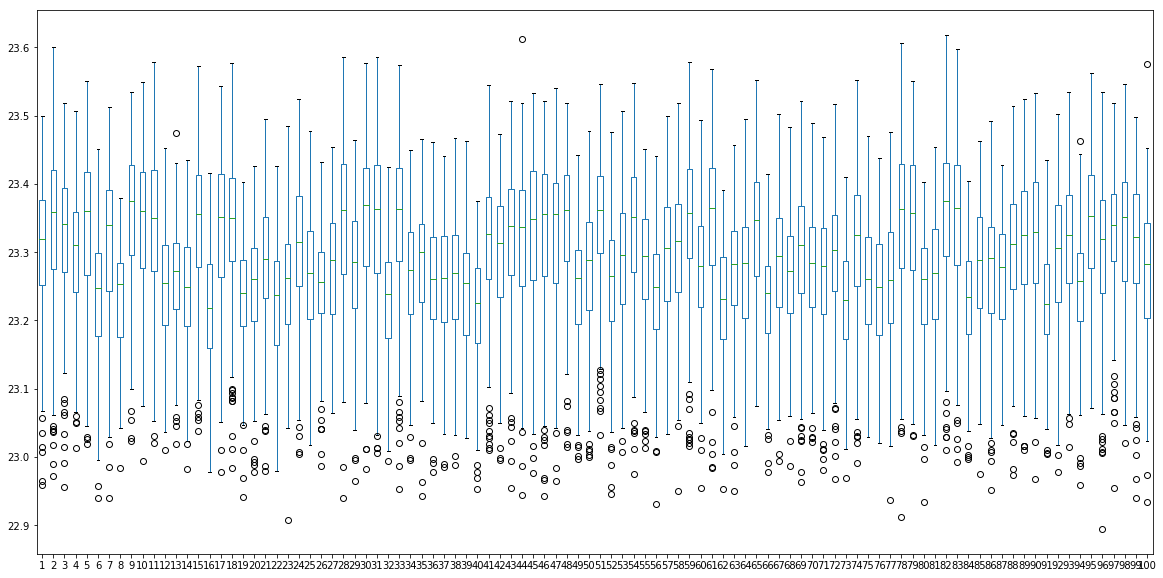

In [10]:
for col in df_train.columns[2:]:
    print(f'<-----Column: {col}---->')
    df_train.pivot(index='runtime', columns='asset_id', values=col).plot(kind='box', figsize=(20, 10))
    plt.show()

From the boxplots we can see that columns 'setting_3', 'tag_1', 'tag_5', 'tag_10', 'tag_16', 'tag_18', 'tag_19' seem to not contribute for the prediction.

The standard deviation also confirms that they do not change, so we can eliminate them from the dataset

In [11]:
drop_col = ['setting_3','tag_1','tag_5','tag_10','tag_16','tag_18','tag_19']
df_train[drop_col].std()

setting_3    0.000000e+00
tag_1        6.537152e-11
tag_5        3.394700e-12
tag_10       4.660829e-13
tag_16       1.556432e-14
tag_18       0.000000e+00
tag_19       0.000000e+00
dtype: float64

In [12]:
# dropping columns with std = 0
df_train.drop(drop_col, axis=1, inplace=True)
df_test.drop(drop_col, axis=1, inplace=True)

We could also look at the distribution of the remained to columns to have an idea of how they are distributed

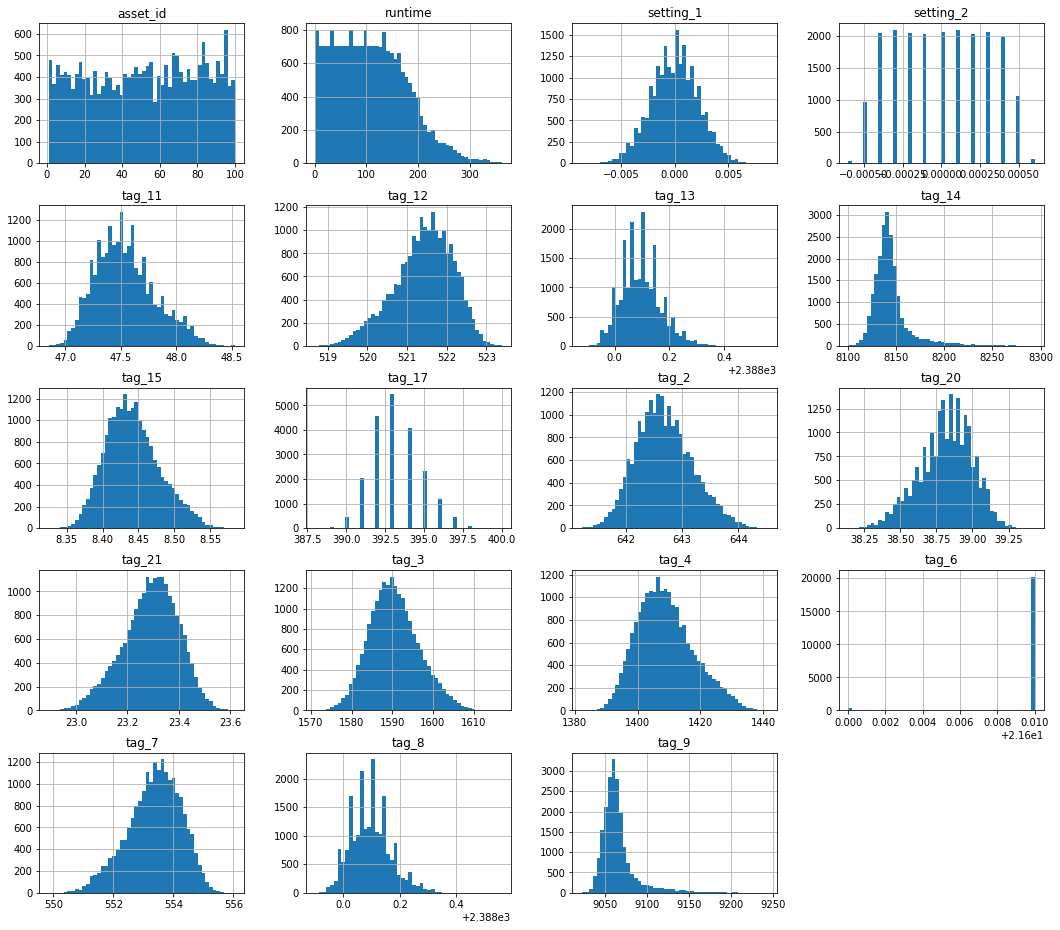

In [13]:
# let's look at the distributions of the remained columns
df_train.hist(bins=50, figsize=(18,16))
plt.show()

Some variables seem to have a similar distribution, and maybe some of them are correlated.
Let's plot the heatmap with the pearson correlation to see if some of them are redundant.

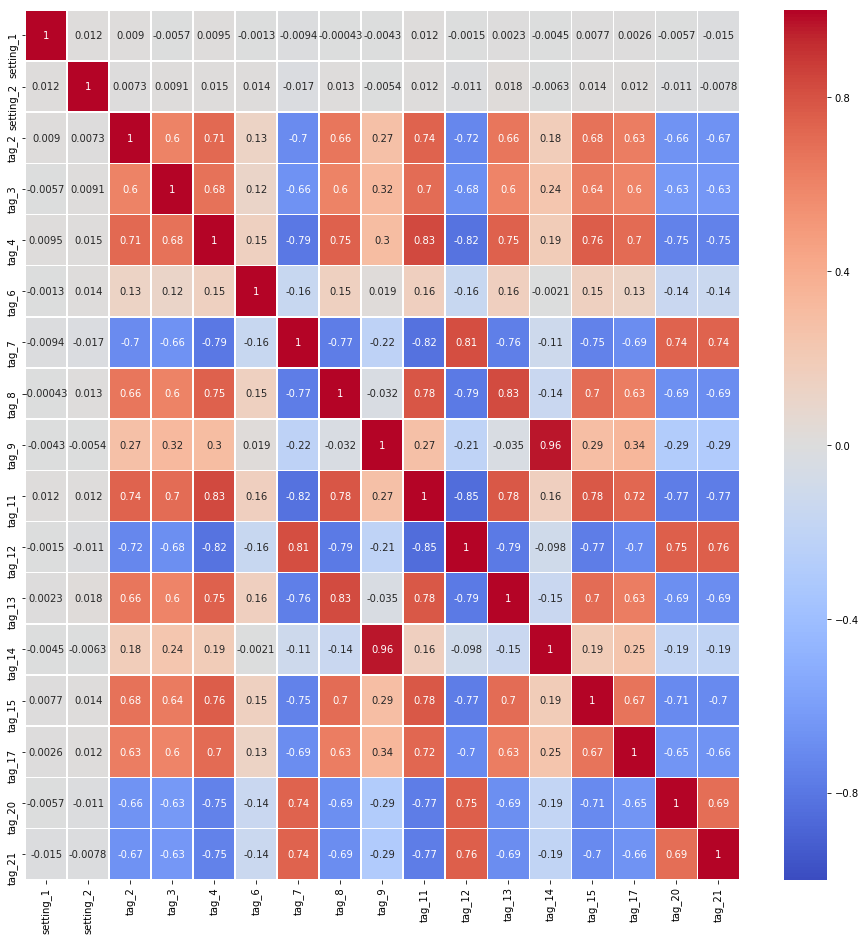

In [14]:
# plotting correlation matrix
plt.figure(figsize=(16,16))
sns.heatmap(df_train.iloc[:,2:].corr(), vmin=-1,
            cmap='coolwarm', annot=True, linewidths=.5)

As we can see, there are highly correlated measures like:
* tag_04 and tag_11 with pearson correlation of:  0.83
* tag_04 and tag_12 with pearson correlation of: -0.81
* tag_07 and tag_11 with pearson correlation of: -0.82
* tag_07 and tag_12 with pearson correlation of:  0.81
* tag_08 and tag_13 with pearson correlation of:  0.82
* tag_09 and tag_14 with pearson correlation of:  0.96
* tag_11 and tag_12 with pearson correlation of: -0.84

We could also analyze the increase or decrease of each variable along their rumtime

<-----tag_2---->


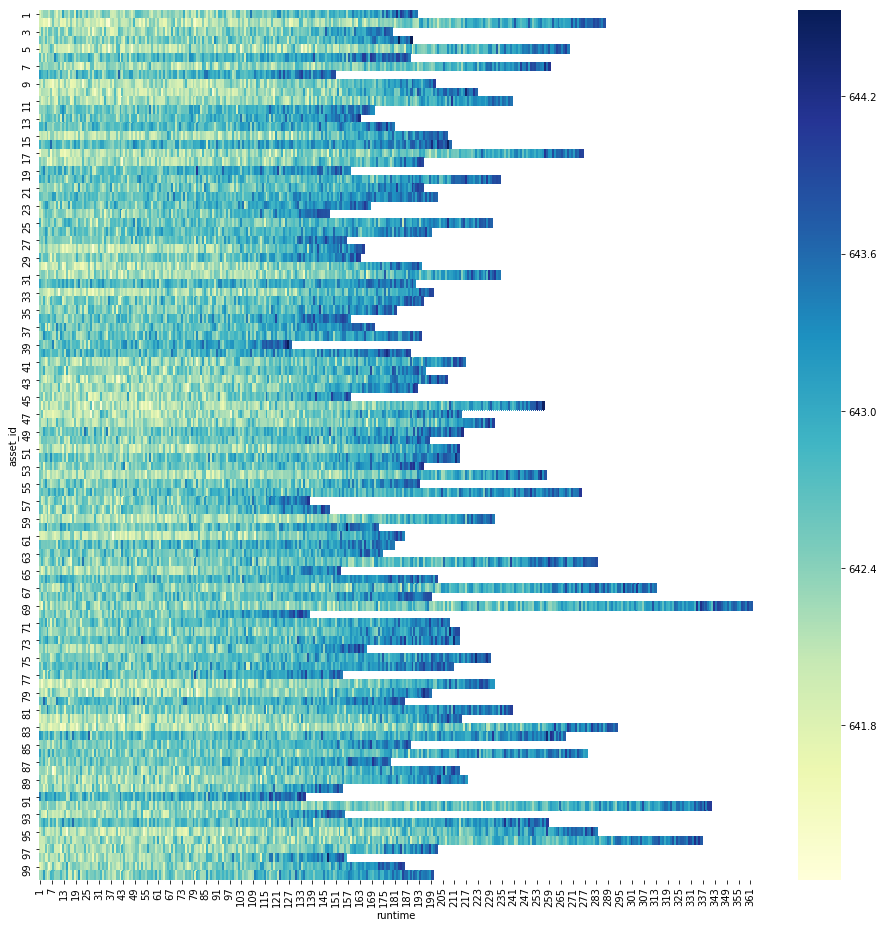

<-----tag_3---->


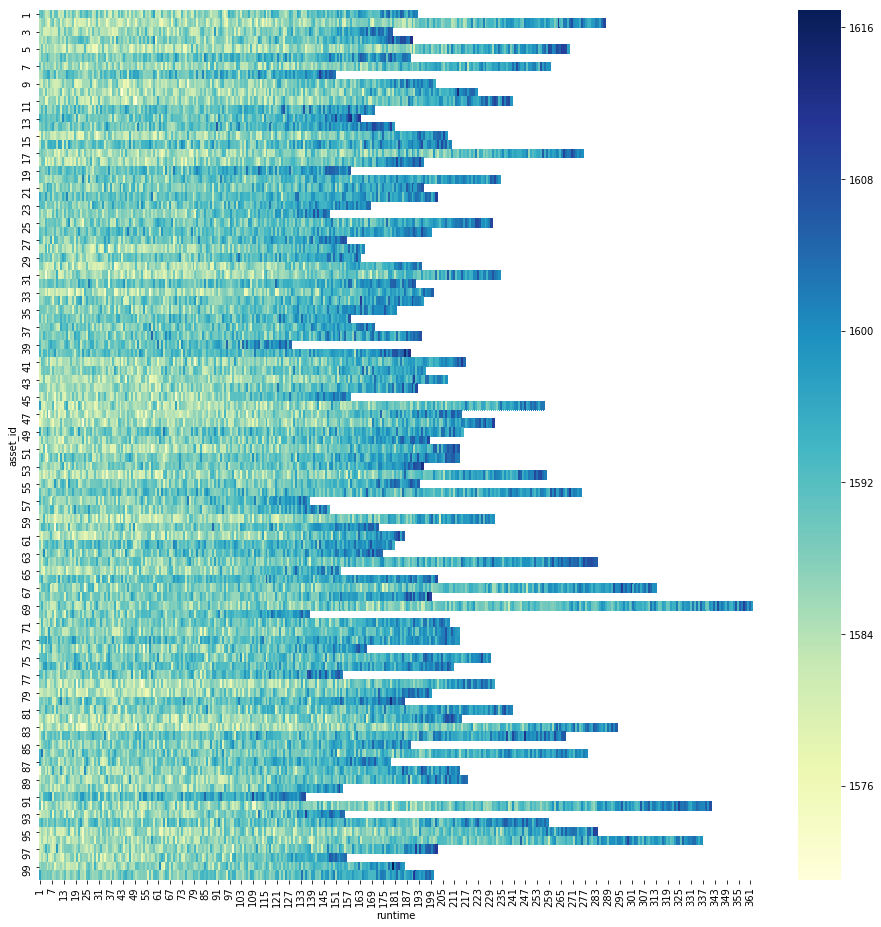

<-----tag_4---->


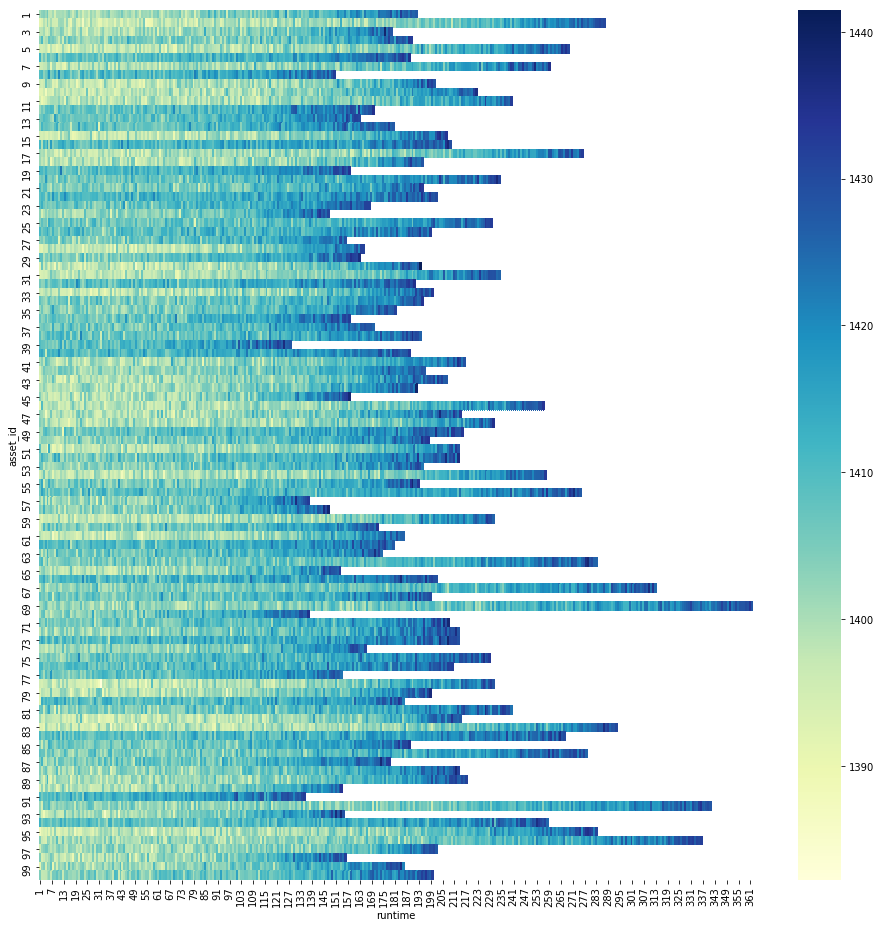

<-----tag_6---->


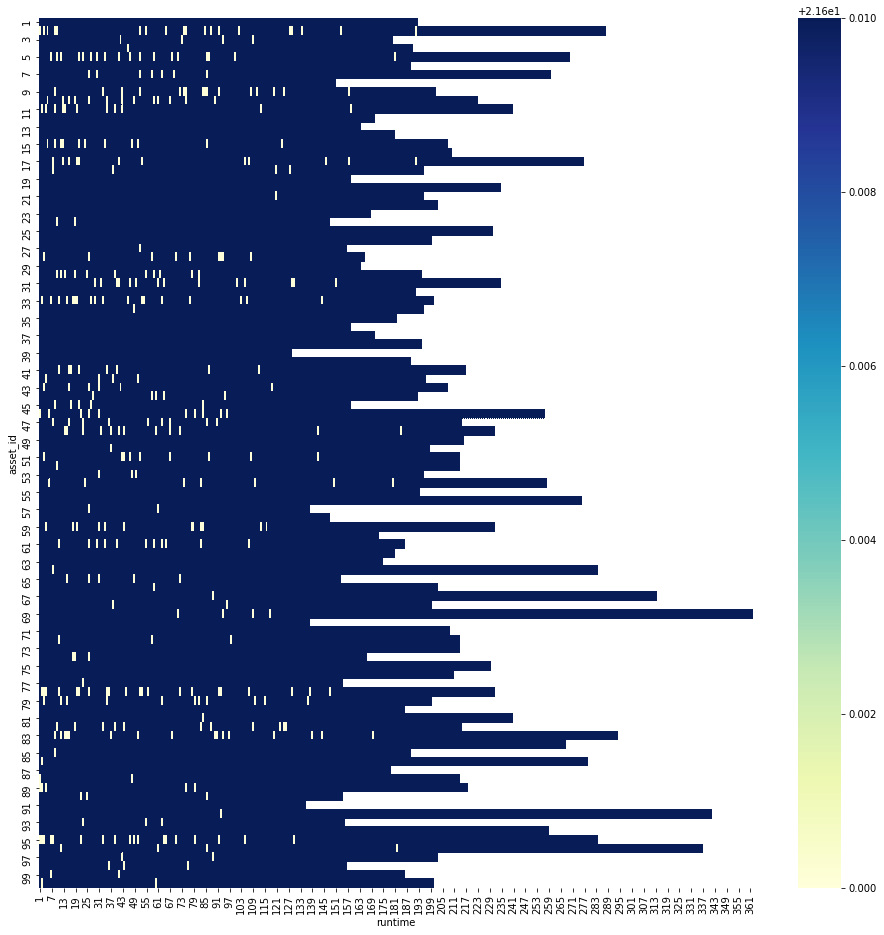

<-----tag_7---->


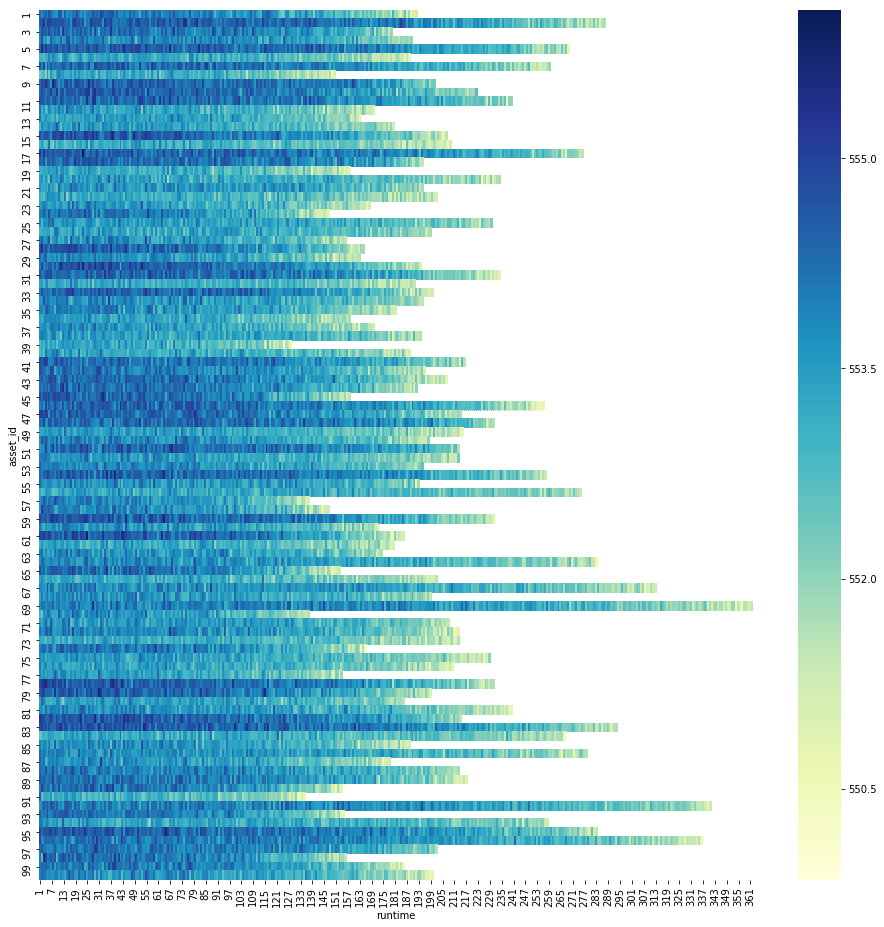

<-----tag_8---->


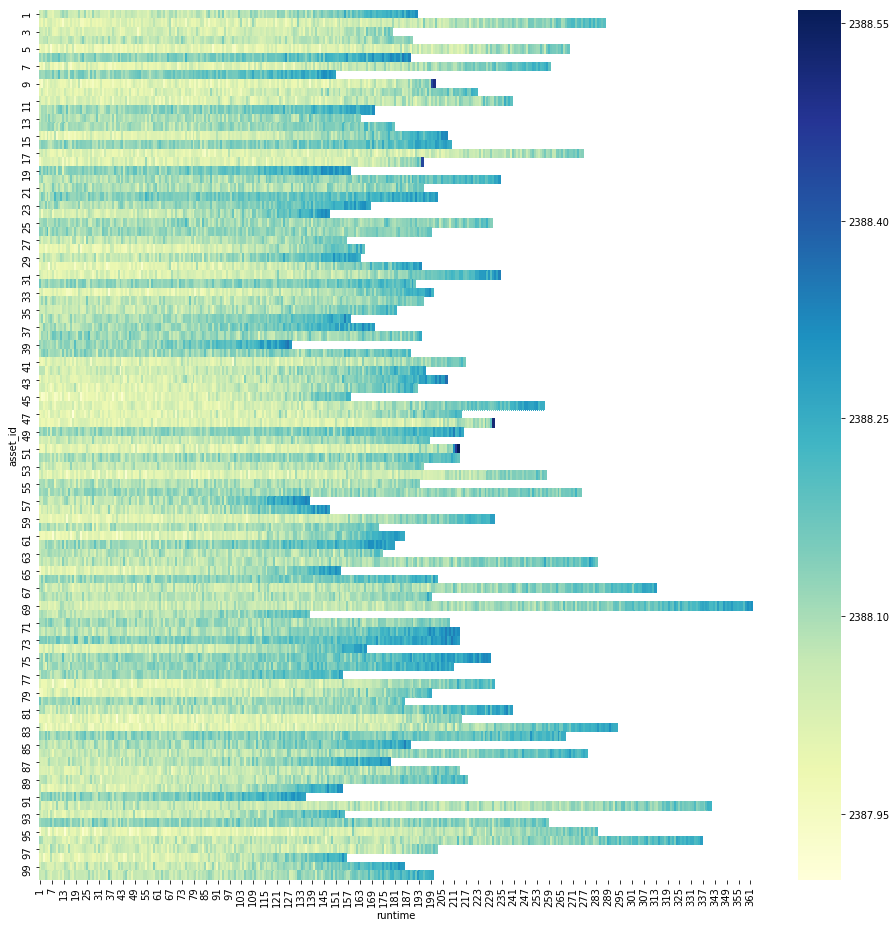

<-----tag_9---->


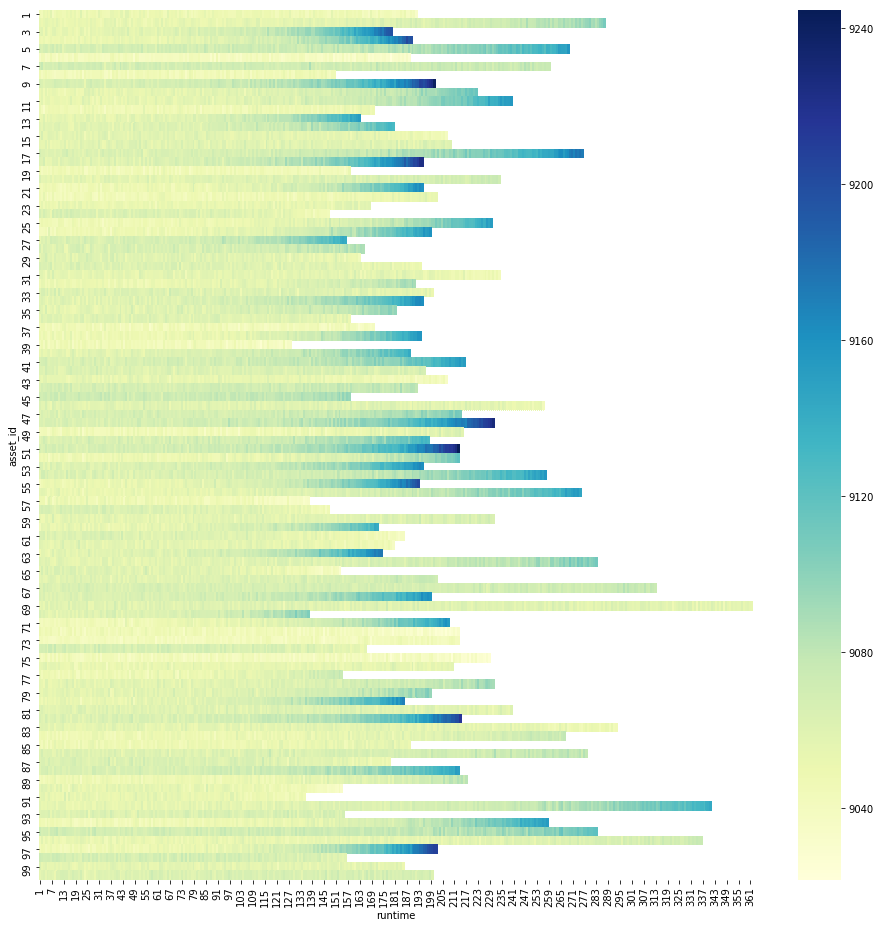

<-----tag_11---->


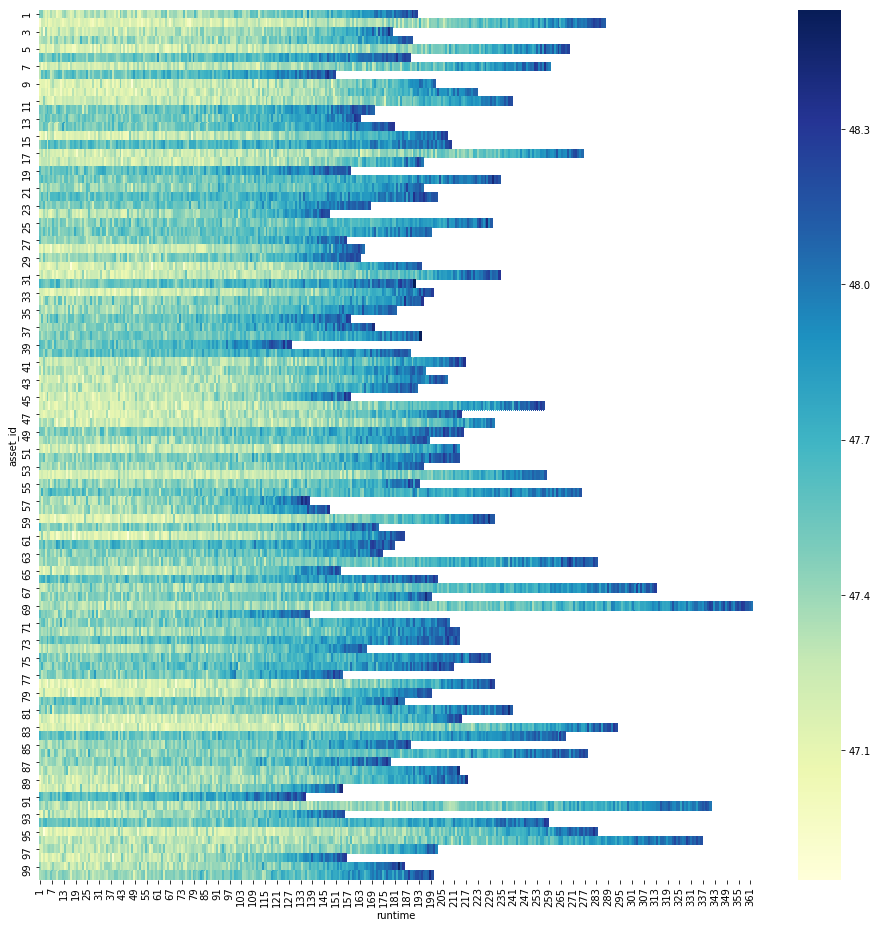

<-----tag_12---->


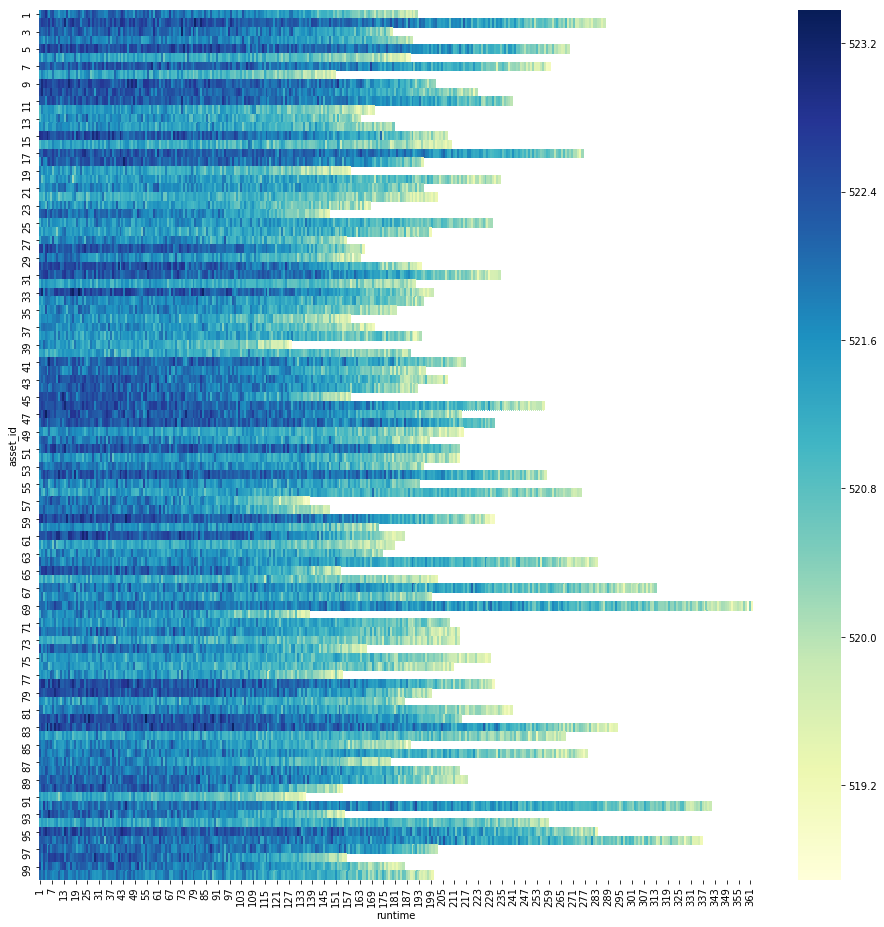

<-----tag_13---->


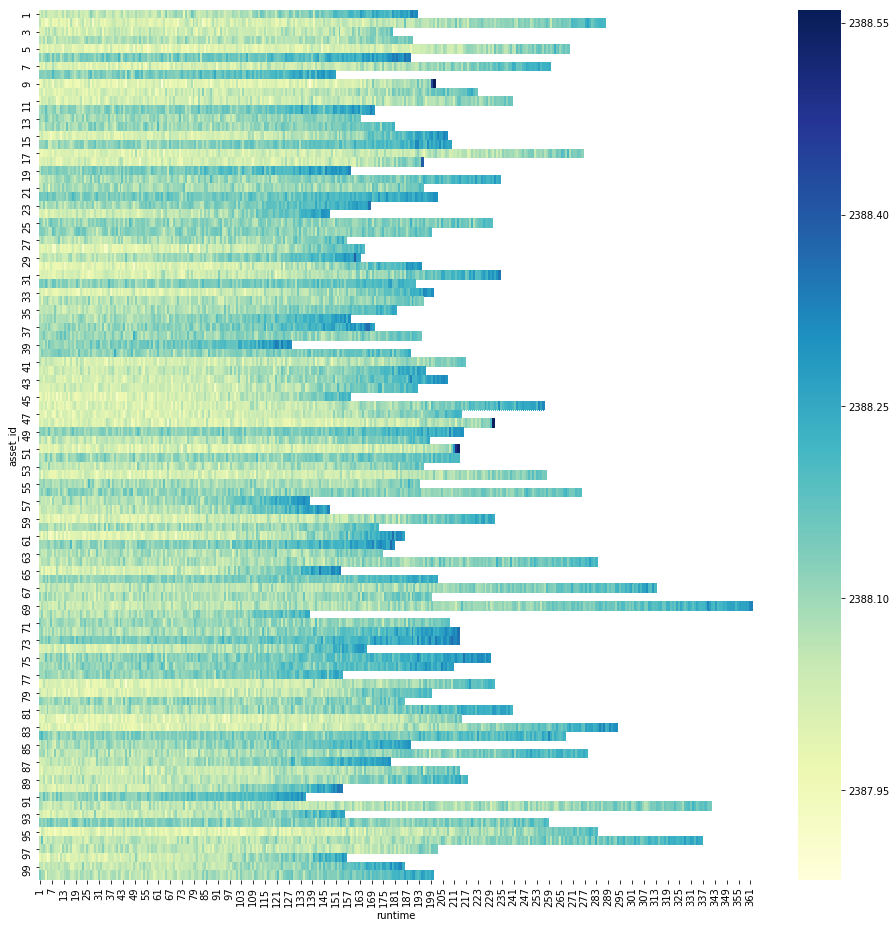

<-----tag_14---->


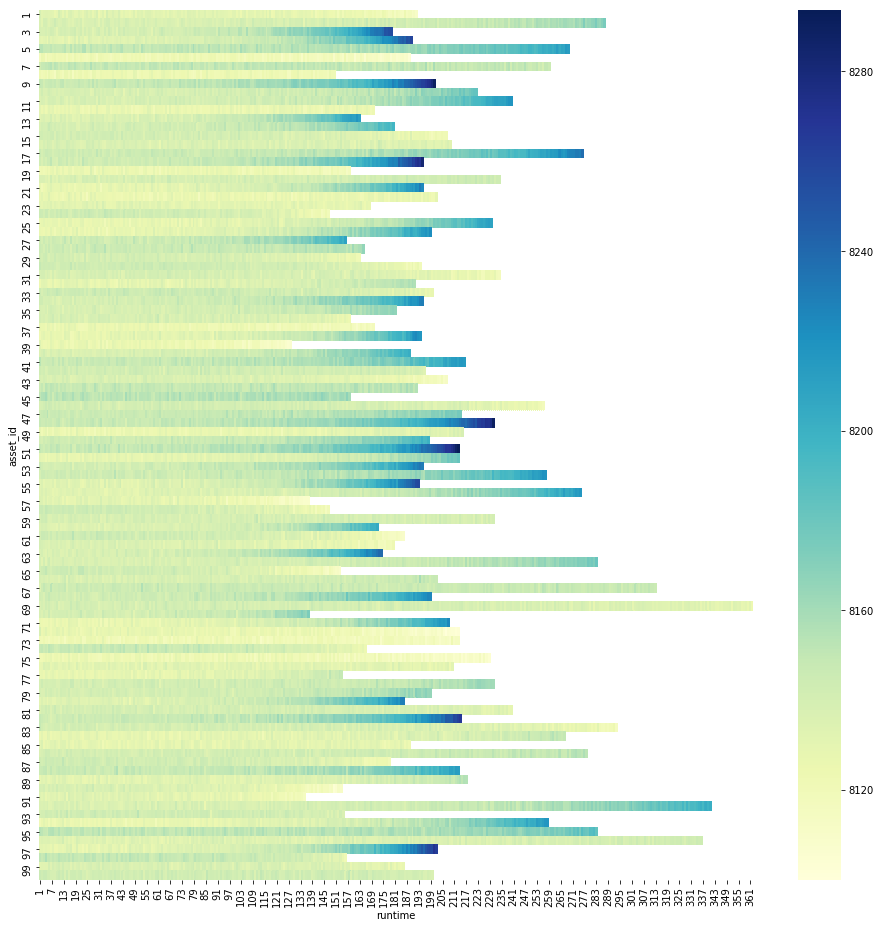

<-----tag_15---->


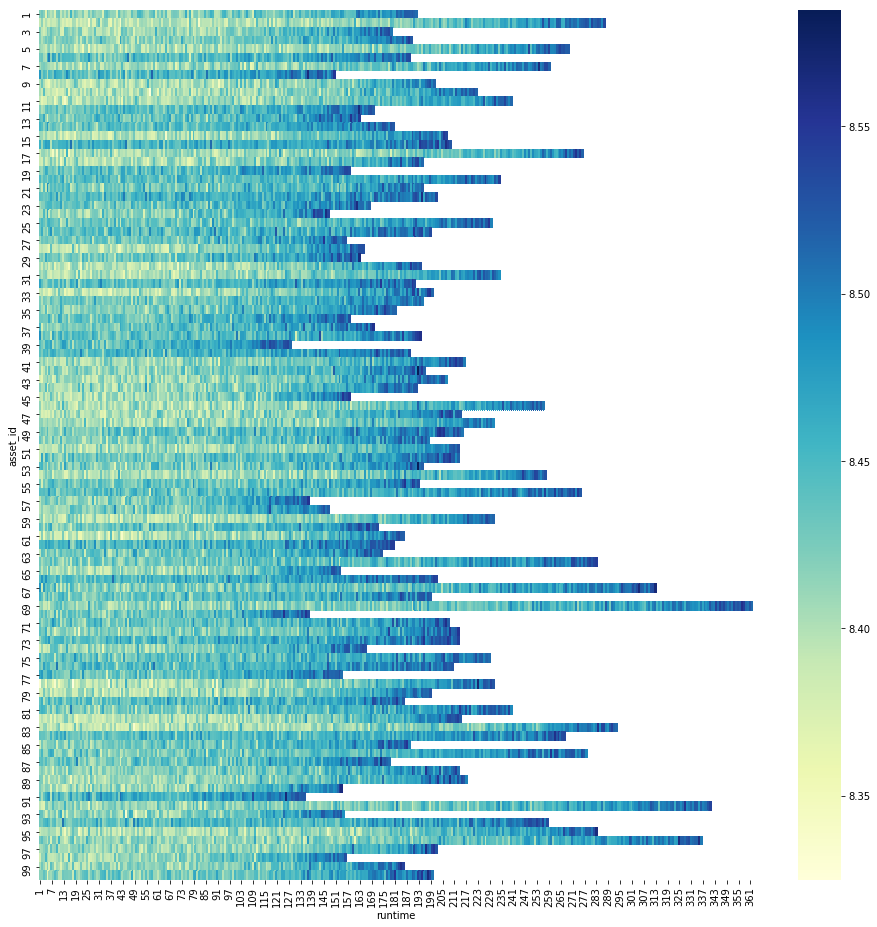

<-----tag_17---->


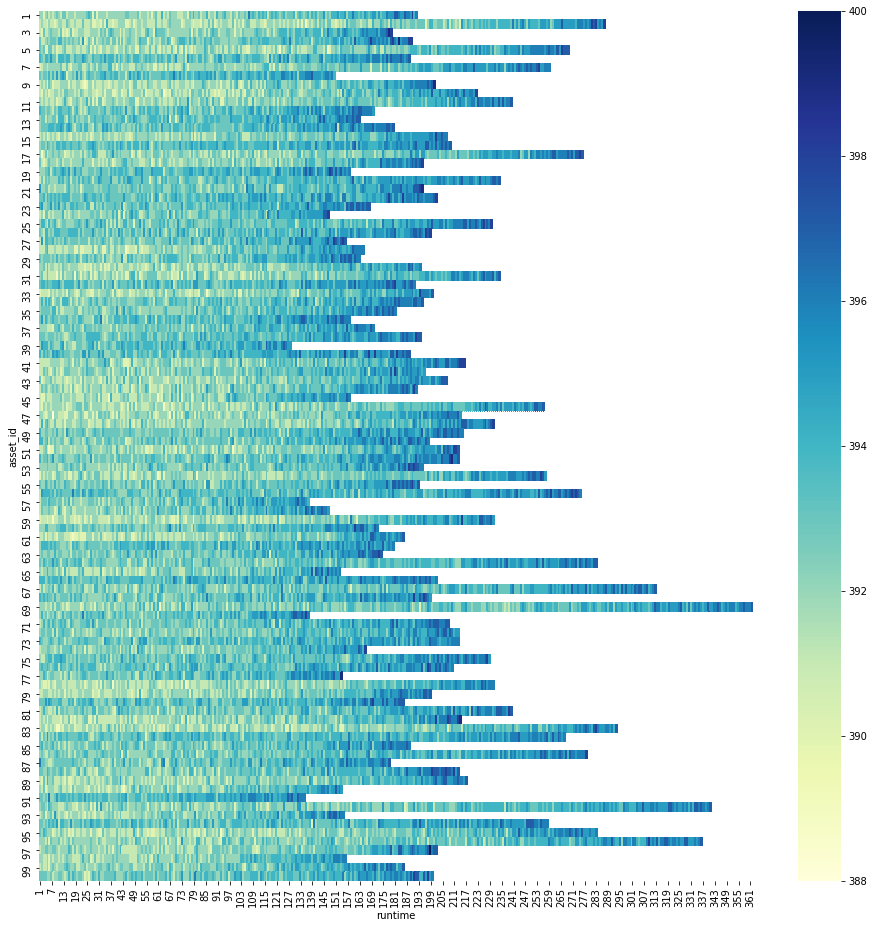

<-----tag_20---->


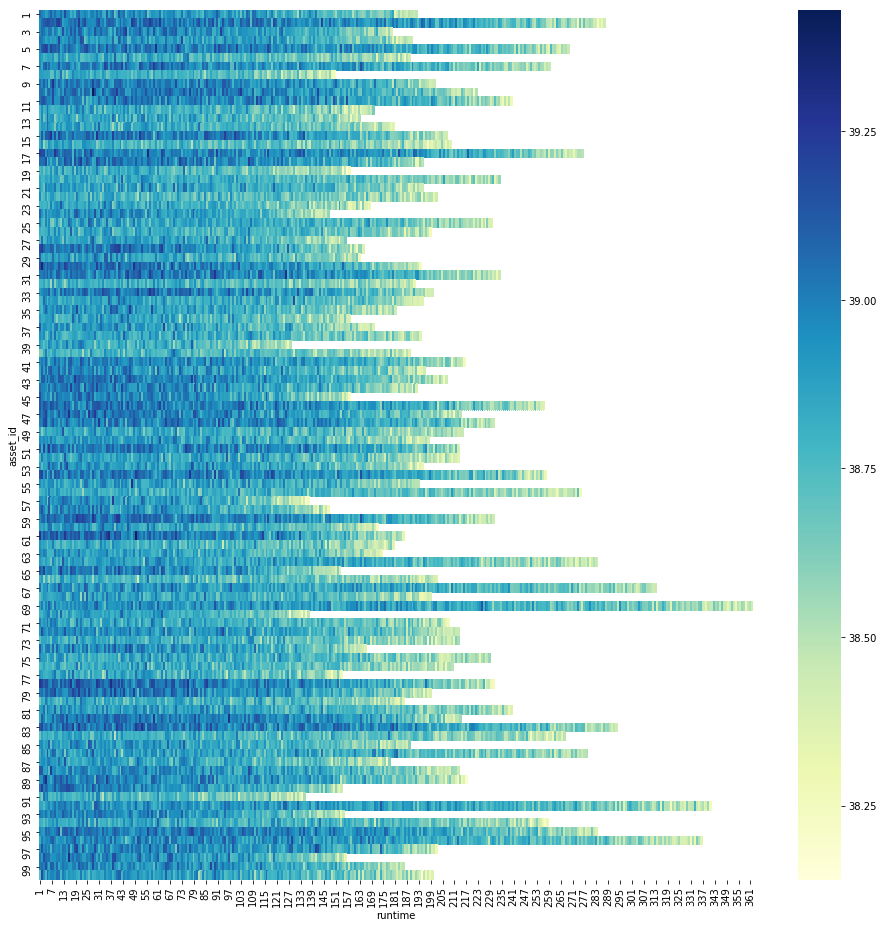

<-----tag_21---->


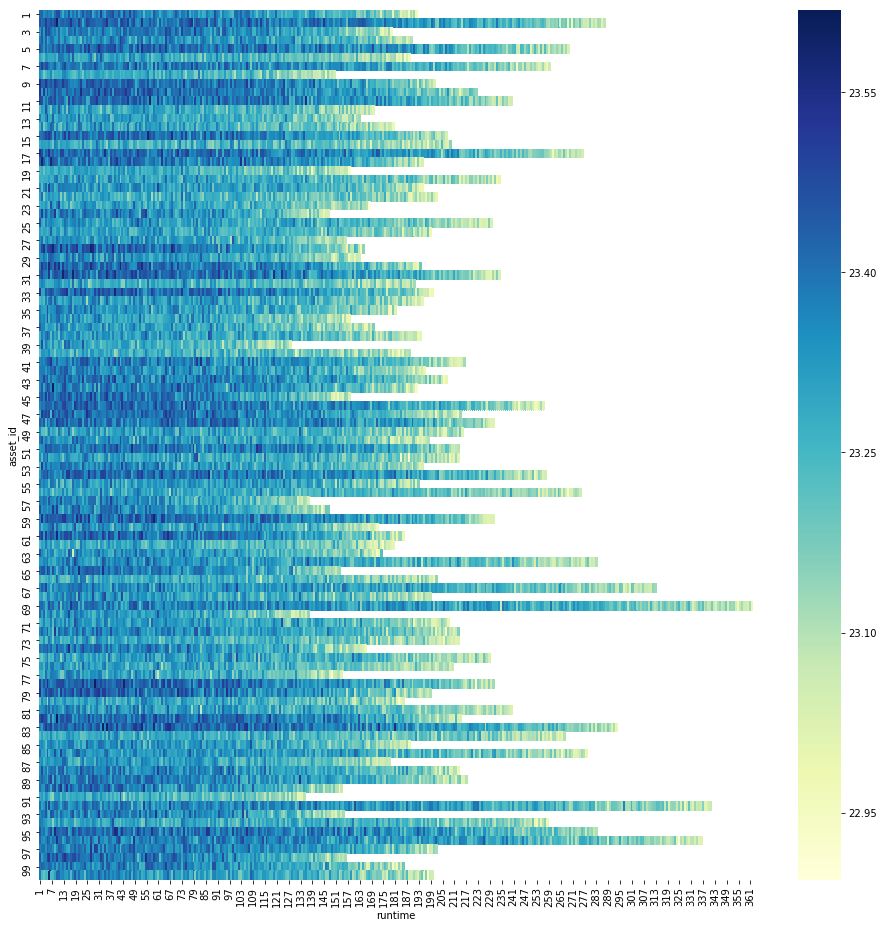

In [15]:
# lets plot each measurement for each asset_id along their useful life
for col in df_train.columns[4:]:
    print(f'<-----{col}---->')
    plt.figure(figsize=(16,16))
    sns.heatmap(df_train.pivot(index='asset_id', columns='runtime', values=col), cmap='YlGnBu')
    plt.show()

We can note here:
* Signals of tags 2, 3, 4, 7, 8, 11, 12, 13, 15, 17, 20, and 21 present similar behaviour, whether raising or falling with the degradation of the equipment

Now, looking at the maximum runtime of each asset, we can see that the average time to failure is 206, the minimum is 128, and the maximum is 362.
We can also see that maxium runtime for test data are lower than train data.

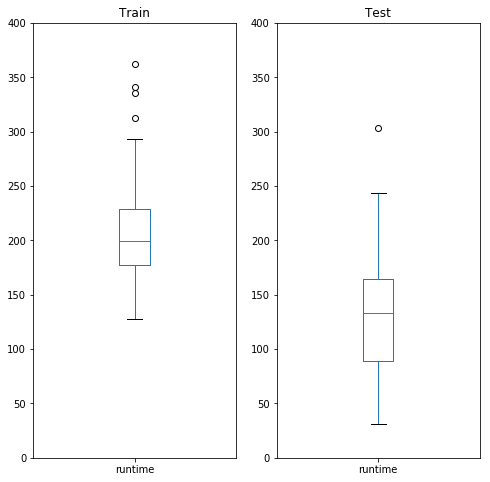

In [16]:
fig, ax = plt.subplots(1, 2,  figsize=(8,8))

ax[0].set_ylim(0, 400)
ax[1].set_ylim(0, 400)

df_train.groupby('asset_id')['runtime'].max().plot(kind='box', ax=ax[0], title='Train')
df_test.groupby('asset_id')['runtime'].max().plot(kind='box', ax=ax[1], title='Test')

In [17]:
# looking at the time each asset_id took until failure

print(df_train.groupby('asset_id')['runtime'].max().describe())

count    100.000000
mean     206.310000
std       46.342749
min      128.000000
25%      177.000000
50%      199.000000
75%      229.250000
max      362.000000
Name: runtime, dtype: float64


### Kaplan Meier 

We could estimate the survival curve of the data using de Kaplan Meier curve.

In [18]:
timeline = np.arange(min(df_train['runtime']), max(df_train['runtime'])+1)

In [19]:
km_durations = df_train.groupby('asset_id')['runtime'].max().tolist()
km_event = len(km_durations) * [1]

In [21]:
kmf = KaplanMeierFitter().fit(km_durations, km_event,timeline=timeline, label='Kaplan Meier Estimate')
wf = WeibullFitter().fit(km_durations, km_event,timeline=timeline, label='WeibullFitter')                                                                         
lnf = LogNormalFitter().fit(km_durations, km_event,timeline=timeline, label='LogNormalFitter')
llf = LogLogisticFitter().fit(km_durations, km_event,timeline=timeline, label='LogLogisticFitter')

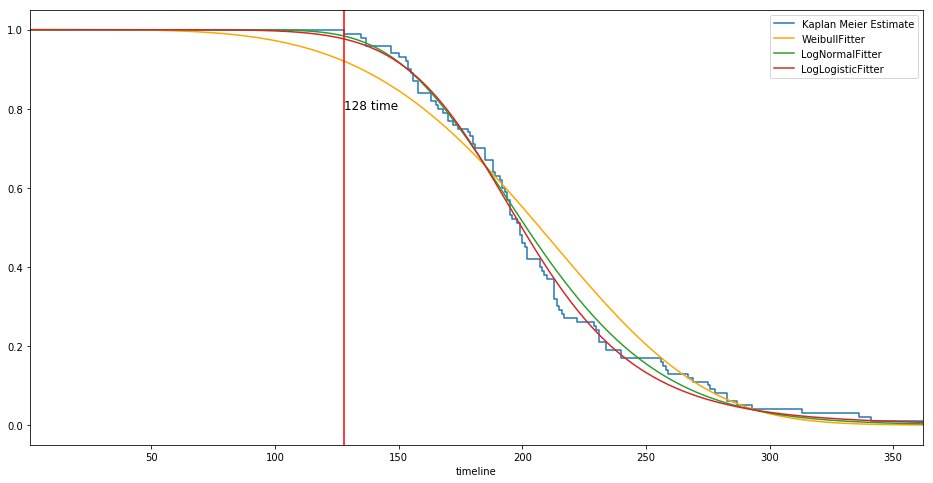

In [22]:
kmf.plot(ci_show=False, figsize=(16,8))
wf.plot_survival_function(ci_show=False,c='orange')
lnf.plot_survival_function(ci_show=False)
llf.plot_survival_function(ci_show=False)


plt.axvline(x=min(km_durations), color='r', label='128')
plt.text(min(km_durations),0.8 ,'128 time', fontsize='large')
plt.show()

From the plot, we can see that in the train data, the machines start to become unavailable after 128 time.
We could also analyze if behaviour of the assets follow a curve like Weibull, LogNormal or LogLogistic

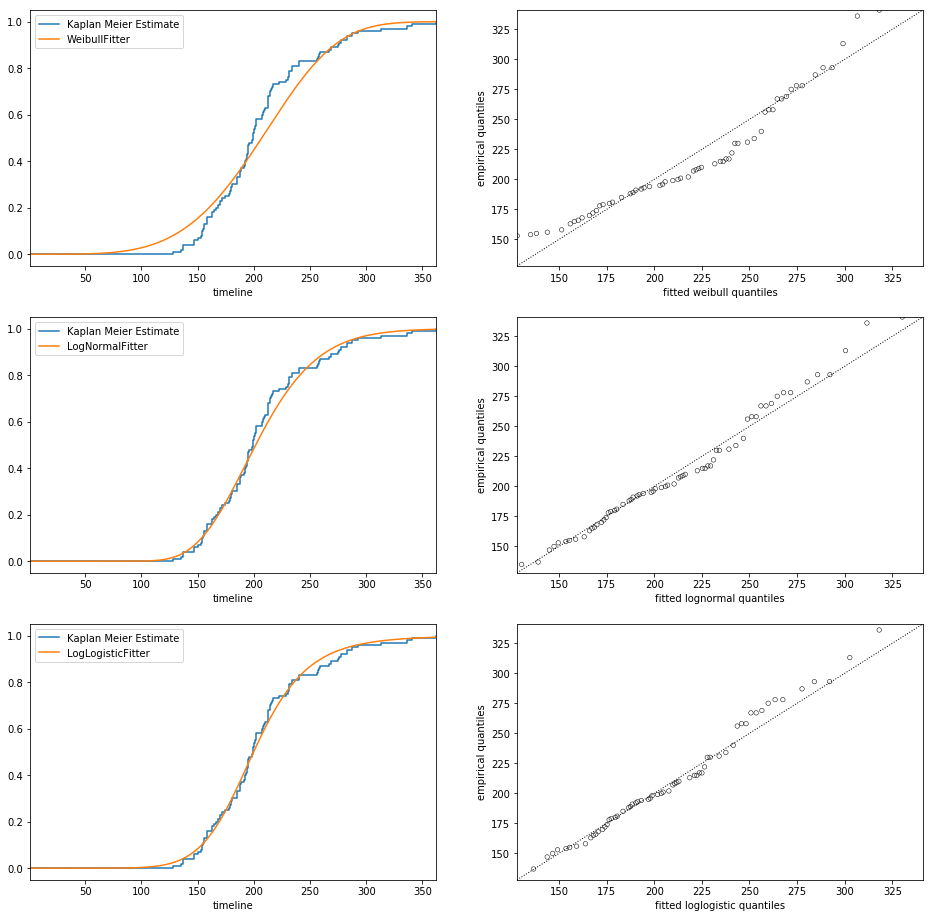

In [23]:
fig, axes = plt.subplots(3, 2,  figsize=(16,16))

# plot what we just fit, along with the KMF estimate
kmf.plot_cumulative_density(ax=axes[0][0], ci_show=False)
wf.plot_cumulative_density(ax=axes[0][0], ci_show=False)
qq_plot(wf, ax=axes[0][1])

kmf.plot_cumulative_density(ax=axes[1][0], ci_show=False)
lnf.plot_cumulative_density(ax=axes[1][0], ci_show=False)
qq_plot(lnf, ax=axes[1][1])

kmf.plot_cumulative_density(ax=axes[2][0], ci_show=False)
llf.plot_cumulative_density(ax=axes[2][0], ci_show=False)
qq_plot(llf, ax=axes[2][1])

From the qq-plot, we see that the Loglogistic curve seem to simulate better the behavior of the accumulated distribution function.

### Creating target

Before creating the Remaining Useful Life (RUL) for each row, we have to determine the maximum runtime for each asset.

In [24]:
df_max_runtime_train = df_train.groupby('asset_id', as_index=False)['runtime'].max().rename(columns={'runtime':'max_runtime'})
df_max_runtime_test = df_test.groupby('asset_id', as_index=False)['runtime'].max().rename(columns={'runtime':'max_runtime'})

In [26]:
df_train = pd.merge(df_train, df_max_runtime_train, how='left', on='asset_id')
df_test = pd.merge(df_test, df_max_runtime_test, how='left', on='asset_id')

Then we can calculate the time to failure (TTF) for every row, which is defined as:

\begin{equation*}
TTF_i = max(cycles) - cycles_i
\end{equation*}

In [27]:
df_train['TTF'] = df_train['max_runtime'] - df_train['runtime']
df_test['TTF'] = df_test['max_runtime'] - df_test['runtime']

Since TTF for each asset has a different length, I will normalize them to express the TTF as a fraction of the remaining runtime.
So our normalized TTF start with value '1' and ends with '0', when the asset fails.
The formula we used is:

\begin{equation*}
fTTF_i = \frac{TTF_i - min(TTF)}{max(TTF) - min(TTF)}
\end{equation*}

In [29]:
def fractionTTF(data,q):
    return(data.TTF[q]-data.TTF.min()) / float(data.TTF.max()-data.TTF.min())

fTTFz = []
fTTF = []

for i in range(df_train['asset_id'].min(),df_train['asset_id'].max()+1):
    dat=df_train[df_train.asset_id==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
df_train['fTTF'] = fTTF

In [30]:
fTTFz = []
fTTF = []

for i in range(df_test['asset_id'].min(),df_test['asset_id'].max()+1):
    dat=df_test[df_test.asset_id==i]
    dat = dat.reset_index(drop=True)
    for q in range(len(dat)):
        fTTFz = fractionTTF(dat, q)
        fTTF.append(fTTFz)
df_test['fTTF'] = fTTF

As we can see, the TTF normalized is constrained between 0 and 1

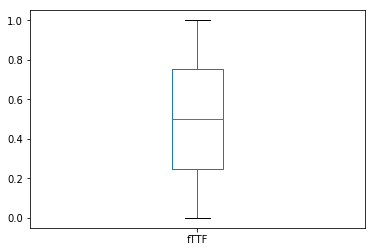

In [32]:
df_train['fTTF'].plot.box()

## Feature Engineering

Now that we have our target, let's create some features to improve the performance of the models.

First of all, I will normalize the data.

In [33]:
scaler = MinMaxScaler()

df_train_sc = df_train.copy()
df_train_sc.iloc[:,2:19] = scaler.fit_transform(df_train_sc.iloc[:,2:19])

df_test_sc = df_test.copy()
df_test_sc.iloc[:,2:19] = scaler.fit_transform(df_test_sc.iloc[:,2:19])

C:\Users\milto\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
C:\Users\milto\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:334: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [34]:
y_train = df_train_sc['fTTF'].copy()
df_train_sc.drop('fTTF', axis=1, inplace=True)

y_test = df_test_sc['fTTF'].copy()
df_test_sc.drop('fTTF', axis=1, inplace=True)

In [35]:
df_train_sc.shape, df_test_sc.shape, y_train.shape, y_test.shape

((20631, 21), (13096, 21), (20631,), (13096,))

I tried to create a cluster using the setting data to group similar assets.
According to the Elbow method, K = 4 seems to be a good number for Kmeans algorithm

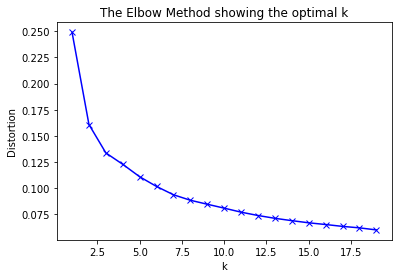

In [36]:
X = df_train_sc[['setting_1', 'setting_2']].copy()

# k means determine k
distortions = []
K = range(1, 20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])

# Plot the elbow
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

Now I will use featuretools to help creating some variables using aggregate functions like (last, max, min, std, skew, mean) on the features

In [37]:
df_train_sc['index'] = df_train_sc.index
df_test_sc['index'] = df_test_sc.index

n_clusters = 4

def make_entityset(data, nclusters, kmeans=None):
    X = data[['setting_1', 'setting_2']]
    if kmeans:
        kmeans=kmeans
    else:
        kmeans = KMeans(n_clusters=n_clusters).fit(X)
    data['settings_clusters'] = kmeans.predict(X)
    
    es = ft.EntitySet('Dataset')
    es.entity_from_dataframe(dataframe=data,
                             entity_id='recordings',
                             index='index',
                             time_index='runtime')

    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='engines',
                        index='asset_id')
    
    es.normalize_entity(base_entity_id='recordings', 
                        new_entity_id='settings_clusters',
                        index='settings_clusters')
    
    return es, kmeans

es, kmeans = make_entityset(df_train_sc, n_clusters)
es

Entityset: Dataset
  Entities:
    recordings [Rows: 20631, Columns: 23]
    engines [Rows: 100, Columns: 2]
    settings_clusters [Rows: 4, Columns: 2]
  Relationships:
    recordings.asset_id -> engines.asset_id
    recordings.settings_clusters -> settings_clusters.settings_clusters

In [38]:
fm, features = ft.dfs(entityset=es, 
                      target_entity='recordings',
                      agg_primitives=['last', 'max', 'min', 'std', 'skew', 'mean'],
                      trans_primitives=[],
                      chunk_size=.26,
                      max_depth=3,
                      verbose=True)

Built 268 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 4/4 chunks


In [39]:
es_test, _ = make_entityset(df_test_sc, n_clusters)

fm_test, features = ft.dfs(entityset=es_test, 
                      target_entity='recordings',
                      agg_primitives=['last', 'max', 'min', 'std', 'skew', 'mean'],
                      trans_primitives=[],
                      chunk_size=.26,
                      max_depth=3,
                      verbose=True)

Built 268 features
Elapsed: 00:03 | Remaining: 00:00 | Progress: 100%|████████████████████████████████████████████| Calculated: 4/4 chunks


We can filter some columns from the dataset that will not be used for training the models

In [61]:
def filter_col(data):
    df = data.loc[:,~data.columns.str.contains('asset')]
    df = df.loc[:,~df.columns.str.contains('index')]
    df = df.loc[:,~df.columns.str.contains('TTF')]
    df = df.loc[:,~df.columns.str.contains('runtime')]
    return df

In [62]:
x_train = filter_col(fm)
x_test = filter_col(fm_test)

In [64]:
x_train.shape, x_test.shape, 

((20631, 225), (13096, 225))

Even filtering some columns, our dataset still has 225 features and some of them may be redundant.

According to the heatmap plot, some features like 'tag_11', 'tag_12', 'tag_13', and 'tag_14' are highly correlated with other features on the dataset, so I created a function to eliminate them during training.

I guess, removing them will decrease the training time without decreasing the performance of the model.

In [68]:
def filter_col_corr(data):
    df = data.loc[:,~data.columns.str.contains('tag_11')]
    df = df.loc[:,~df.columns.str.contains('tag_12')]
    df = df.loc[:,~df.columns.str.contains('tag_13')]
    df = df.loc[:,~df.columns.str.contains('tag_14')]
    return df

Now I will create the model function as follows:

In [69]:
def fit_sub(x_train, y_train, x_test, y_test, mdl):
    x_train = x_train.values
    y_train = y_train.values
    x_test = x_test.values
    y_test = y_test.values
    
    print(x_train.shape)
    if mdl is None:
        mdl = SVR(gamma='scale')

    y_cv = cross_val_predict(mdl, x_train, y_train, cv=3)

    mdl.fit(x_train, y_train)
    pred_y = mdl.predict(x_test)

    print("cv test mse: %s" % mean_squared_error(y_cv, y_train))
    print("testing units mse: %s" % mean_squared_error(pred_y, y_test))

    res_full = {
        'dy_train_cv': y_cv - y_train,
        'dy_test': pred_y - y_test,
        'y_train_p_cv': y_cv,
        'pred_y': pred_y
    }
    return res_full

def fit_and_test_clf(x_train, y_train, x_test, y_test, mdl=None):
    print('\ntraining using full dataset:\n')
    res_full = fit_sub(x_train, y_train, x_test, y_test, mdl)

    print('\ntraining without correlated features:\n')
    x_train_corr = filter_col_corr(x_train)
    x_test_corr = filter_col_corr(x_test)    
    res_less_corr = fit_sub(x_train_corr, y_train, x_test_corr, y_test, mdl)
    
    return res_full, res_less_corr

### Model

I applied several regressors to predict the RUL, using the TFFx as the target.

In [70]:
res_arr = {}

models = {    
    "SVM": SVR(gamma='scale'),
    "Nearest Neighbor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Neural Net": MLPRegressor(),
    'lr': LinearRegression(),
    'lasso': Lasso(alpha=.1),
    'Bridge': BayesianRidge(),
    'ridge': Ridge()
}

scoring = mean_squared_error
for name, clf in models.items():
    
    print('\n=========================\n')
    
    if name in res_arr:
        print('skipping model because already found: ' + name )
        continue
        
    print('fitting model: ' + name )
    mdl = models[name]
    
    res_full, res_red = fit_and_test_clf(x_train, y_train, x_test, y_test, mdl=mdl)    
    
    
    res_arr[name] = {
        'res_full': res_full,
        'res_red': res_red
    }



fitting model: SVM

training using full dataset:

(20631, 225)
cv test mse: 0.01939611615137668
testing units mse: 0.07845538192662174

training without correlated features:

(20631, 173)
cv test mse: 0.02114752675839286
testing units mse: 0.06879466151984824


fitting model: Nearest Neighbor

training using full dataset:

(20631, 225)
cv test mse: 0.026099193798035557
testing units mse: 0.06209354409816727

training without correlated features:

(20631, 173)
cv test mse: 0.030782182879266387
testing units mse: 0.062067920853379886


fitting model: Decision Tree

training using full dataset:

(20631, 225)
cv test mse: 0.02855103287827833
testing units mse: 0.09804877289456877

training without correlated features:

(20631, 173)
cv test mse: 0.03319710086805536
testing units mse: 0.09764684239102209


fitting model: Random Forest

training using full dataset:

(20631, 225)
cv test mse: 0.012456747577126047
testing units mse: 0.07845866201100883

training without correlated features:



We can visualize the MSE for each regressor for the cross-validation on the full training set, on the full test set, on the full reduced training set, and on the reduced test set on the plot below:

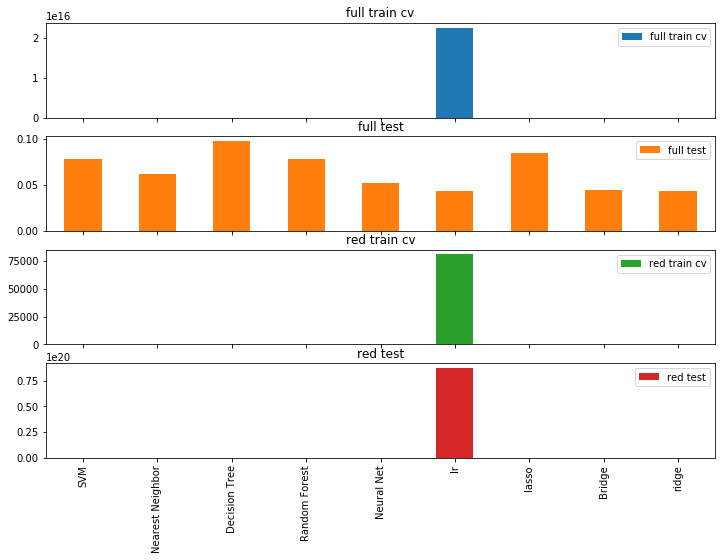

In [72]:
df_loc = pd.DataFrame(
{
    'full train cv': [np.mean(dc2['res_full']['dy_train_cv'] ** 2) for dc2 in res_arr.values()],
    'full test': [np.mean(dc2['res_full']['dy_test'] ** 2) for dc2 in res_arr.values()],
    'red train cv': [np.mean(dc2['res_red']['dy_train_cv'] ** 2) for dc2 in res_arr.values()],
    'red test': [np.mean(dc2['res_red']['dy_test'] ** 2) for dc2 in res_arr.values()],
}, index=res_arr.keys())  

axes = df_loc.plot.bar(subplots=True, figsize=(12, 8))

LinearRegression presented higher MSE than the other regressors, so I eliminated it from the plot to better visualize the MSE of the other regressors

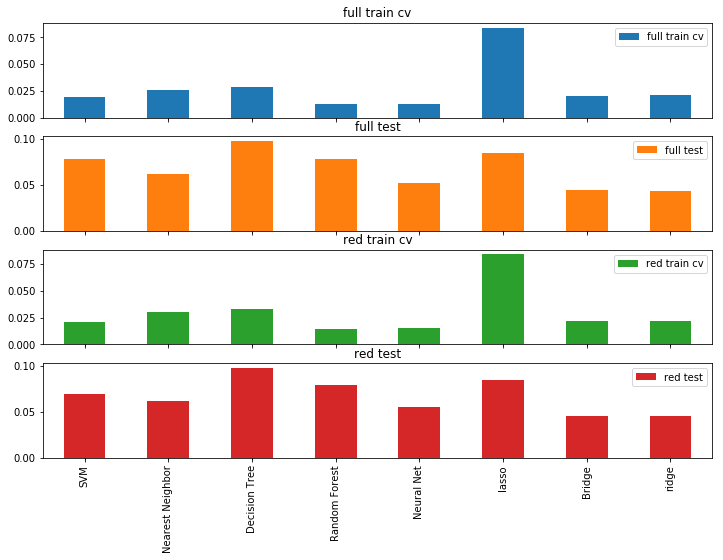

In [73]:
axes = df_loc[df_loc.index != 'lr'].plot.bar(subplots=True, figsize=(12, 8))

As we can see, the neural network, bridge and ridge seem to be the best regressors.

I opted to train the final model with a Keras neural network with hidden layer of 8 neurons, and 1 output neuron that will estimate the RUL.

P.s.: I tried adding more layers and neurons, but the MSE did not improve.

In [74]:
model = Sequential([
    Dense(8, input_dim=225, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal')
])
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, nb_epoch=20, verbose=2)

C:\Users\milto\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  
W1203 03:52:15.653446  4824 deprecation_wrapper.py:119] From C:\Users\milto\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:422: The name tf.global_variables is deprecated. Please use tf.compat.v1.global_variables instead.



Epoch 1/20
 - 1s - loss: 0.0630
Epoch 2/20
 - 1s - loss: 0.0156
Epoch 3/20
 - 1s - loss: 0.0121
Epoch 4/20
 - 1s - loss: 0.0115
Epoch 5/20
 - 1s - loss: 0.0110
Epoch 6/20
 - 1s - loss: 0.0107
Epoch 7/20
 - 1s - loss: 0.0106
Epoch 8/20
 - 1s - loss: 0.0105
Epoch 9/20
 - 1s - loss: 0.0105
Epoch 10/20
 - 1s - loss: 0.0105
Epoch 11/20
 - 1s - loss: 0.0104
Epoch 12/20
 - 1s - loss: 0.0103
Epoch 13/20
 - 1s - loss: 0.0102
Epoch 14/20
 - 1s - loss: 0.0102
Epoch 15/20
 - 1s - loss: 0.0101
Epoch 16/20
 - 1s - loss: 0.0102
Epoch 17/20
 - 1s - loss: 0.0101
Epoch 18/20
 - 1s - loss: 0.0100
Epoch 19/20
 - 1s - loss: 0.0101
Epoch 20/20
 - 1s - loss: 0.0099


The mean squared error now for the neural network is:

In [75]:
y_pred = model.predict(x_test)
mean_squared_error(y_pred, y_test)

0.05012690249945615

We can also look at the mean squared error using the reduced dataset

In [78]:
model_red = Sequential([
    Dense(8, input_dim=173, kernel_initializer='normal', activation='relu'),
    Dense(1, kernel_initializer='normal')
])
model_red.compile(loss='mean_squared_error', optimizer='adam')

x_train_corr = filter_col_corr(x_train)
x_test_corr = filter_col_corr(x_test)

model_red.fit(x_train_corr, y_train, nb_epoch=20, verbose=2)
y_pred_red = model_red.predict(x_test_corr)
mean_squared_error(y_pred_red, y_test)

C:\Users\milto\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  # Remove the CWD from sys.path while we load stuff.


Epoch 1/20
 - 1s - loss: 0.0684
Epoch 2/20
 - 1s - loss: 0.0193
Epoch 3/20
 - 1s - loss: 0.0153
Epoch 4/20
 - 1s - loss: 0.0144
Epoch 5/20
 - 1s - loss: 0.0142
Epoch 6/20
 - 1s - loss: 0.0139
Epoch 7/20
 - 1s - loss: 0.0137
Epoch 8/20
 - 1s - loss: 0.0136
Epoch 9/20
 - 1s - loss: 0.0135
Epoch 10/20
 - 1s - loss: 0.0135
Epoch 11/20
 - 1s - loss: 0.0133
Epoch 12/20
 - 1s - loss: 0.0131
Epoch 13/20
 - 1s - loss: 0.0133
Epoch 14/20
 - 1s - loss: 0.0131
Epoch 15/20
 - 1s - loss: 0.0132
Epoch 16/20
 - 1s - loss: 0.0131
Epoch 17/20
 - 1s - loss: 0.0129
Epoch 18/20
 - 1s - loss: 0.0128
Epoch 19/20
 - 1s - loss: 0.0131
Epoch 20/20
 - 1s - loss: 0.0129


0.046950973266737486

The MSE of with the reduced dataset was slightly better than training with the full dataset, so I chose the predictions of the fraction RUL originated from the model trained on the reduced dataset.

We can also note the the MSE on testset of the Keras neural network (0.0469) is better than the MSE of the default sklearn neural network (0.0549)

Now we have to convert the fraction of remaining life (0.00-1.00) to remaining useful life as expressed in runtime.

For this, we need a column with the maximum number of runtime per asset that were already in the testset, and the predicted total runtime per asset, which is obtained as follows:

\begin{equation*}
max(predicted runtime_i) = \frac{runtime_i}{(1-predicted fTTF_i)}
\end{equation*}

In [81]:
df_test['score'] = y_pred_red

In [82]:
def totcycles(data):
    return(data['runtime'] / (1-data['score']))
    
df_test['max_pred_runtime'] = totcycles(df_test)

Finally, the RUL is obtained subtracting the maximum runtime per asset from the predicted total runtime per asset:

\begin{equation*}
RUL_i = max(predicted cycles_i) - max(cycles)
\end{equation*}

In [83]:
def RULfunction(data):
    return(data['max_pred_runtime'] - data['max_runtime'])

df_test['RUL'] = RULfunction(df_test)

The following will compute the RUL per asset (based on the maximum runtime) from the RUL column that contains predicted values for each row.

In [84]:
df_max = df_test.groupby('asset_id', as_index=False)['runtime'].max()

In [92]:
df_submit = pd.merge(df_max, df_test[['asset_id', 'runtime', 'RUL']] , on=['asset_id', 'runtime'])

In [93]:
df_submit.index = df_submit['asset_id']

In [94]:
df_submit.drop(['asset_id','runtime'], axis=1, inplace=True)

In [95]:
df_submit

,RUL
asset_id,
1,28.546898
2,63.767891
3,41.840149
4,12.164612
5,54.173599
...,...
96,115.397263
97,14.790268
98,17.788223


In [96]:
df_submit.to_csv('df_submit.csv')

### Final Question: how will the maintenance team use your model to reduce costs?

The maintenance team could analyze how much time the asset could probably run before failure, and when its useful life is almost at the end, they can do maintenance. In this way, the team can reduce costs by not doing maintenance on unnecessary assets.

They can also prioritize which assets to do maintenance according to the assets that have the lowest predicted RUL.